In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mannwhitneyu

In [17]:
df = pd.read_csv('results.csv')
df['problem'] = df['problem'].str.replace(r'_?Results', '', regex=True)
df['model'] = df['model'].replace({'PaLM': 'PaLM 2', 
                                   'Claude 2': 'Claude 2',
                                   'Claude Instant': 'Claude Instant 1.2',
                                   'GPT 3.5 Turbo': 'GPT 3.5 Turbo',
                                   'GPT 4 Turbo': 'GPT 4 Turbo',
                                   'Mistral': 'Mistra-7bl',
                                   'Mpt': 'MPT-30b',
                                   'Phi': 'Phi-1.5',
                                   'Vicuna': 'Vicuna-13b',
                                   'Yi': 'Yi-34b'})

df['complexity'] = df['complexity'].replace({
                                    'np-cmp': 'NP-Complete', 
                                    'p': 'P',
                                    'np-hard': 'NP-Hard'
                                    })

df.head(10)

,model,problem,level,Average accuracy,Failure,weighted_accuracy,weighted_failed,complexity,lvl_correctness,is_close
0,Vicuna-13b,gcp_d,Lvl 1,0.0,0.9,0.000000,0.09,NP-Complete,"['failed', 'failed', 'failed', 'failed', 'fail...",False
1,Vicuna-13b,gcp_d,Lvl 2,0.0,0.9,0.000000,0.09,NP-Complete,"[False, 'failed', 'failed', 'failed', 'failed'...",False
2,Vicuna-13b,gcp_d,Lvl 3,0.2,0.5,0.010909,0.05,NP-Complete,"[True, False, False, True, False, 'failed', 'f...",False
3,Vicuna-13b,gcp_d,Lvl 4,0.1,0.4,0.007273,0.04,NP-Complete,"[False, False, 'failed', True, 'failed', False...",False
4,Vicuna-13b,gcp_d,Lvl 5,0.2,0.5,0.018182,0.05,NP-Complete,"[True, 'failed', False, 'failed', True, 'faile...",False
5,Vicuna-13b,gcp_d,Lvl 6,0.2,0.5,0.021818,0.05,NP-Complete,"['failed', False, True, 'failed', 'failed', 'f...",False
6,Vicuna-13b,gcp_d,Lvl 7,0.6,0.0,0.076364,0.00,NP-Complete,"[False, True, True, True, False, False, True, ...",False
7,Vicuna-13b,gcp_d,Lvl 8,0.5,0.1,0.072727,0.01,NP-Complete,"[True, False, True, True, False, False, True, ...",False
8,Vicuna-13b,gcp_d,Lvl 9,0.5,0.4,0.081818,0.04,NP-Complete,"[True, 'failed', 'failed', 'failed', False, Tr...",False
9,Vicuna-13b,gcp_d,Lvl 10,0.3,0.5,0.054545,0.05,NP-Complete,"['failed', True, False, False, 'failed', 'fail...",False


In [18]:
set(df['model'].to_list())

{'Claude 2',
 'Claude Instant 1.2',
 'GPT 3.5 Turbo',
 'GPT 4 Turbo',
 'MPT-30b',
 'Mistra-7bl',
 'PaLM 2',
 'Phi-1.5',
 'Vicuna-13b',
 'Yi-34b'}

In [19]:
model_df = df.groupby(['model', 'complexity'])['Average accuracy'].agg(list).reset_index()
print(model_df)

                 model   complexity  \
0             Claude 2  NP-Complete   
1             Claude 2      NP-Hard   
2             Claude 2            P   
3   Claude Instant 1.2  NP-Complete   
4   Claude Instant 1.2      NP-Hard   
5   Claude Instant 1.2            P   
6        GPT 3.5 Turbo  NP-Complete   
7        GPT 3.5 Turbo      NP-Hard   
8        GPT 3.5 Turbo            P   
9          GPT 4 Turbo  NP-Complete   
10         GPT 4 Turbo      NP-Hard   
11         GPT 4 Turbo            P   
12             MPT-30b  NP-Complete   
13             MPT-30b      NP-Hard   
14             MPT-30b            P   
15          Mistra-7bl  NP-Complete   
16          Mistra-7bl      NP-Hard   
17          Mistra-7bl            P   
18              PaLM 2  NP-Complete   
19              PaLM 2      NP-Hard   
20              PaLM 2            P   
21             Phi-1.5  NP-Complete   
22             Phi-1.5      NP-Hard   
23             Phi-1.5            P   
24          Vicuna-13b  N

In [20]:
from matplotlib import rcParams

rcParams['figure.dpi'] = 500
rcParams['savefig.dpi'] = 500
rcParams['figure.figsize'] = 6,4
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 18
rcParams['axes.labelsize'] = 18
rcParams['axes.titlesize'] = 18
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 18
rcParams['legend.fontsize'] = 18
rcParams['figure.titlesize'] = 18

In [47]:
import itertools
from scipy.stats import wilcoxon

colors = {'P': 'lightblue', 'NP-Complete': 'steelblue', 'NP-Hard': 'navy'}
complexities = ['P', 'NP-Complete', 'NP-Hard']

def wilcoxon_test(mdf, complexity_pairs):
    # Perform Wilcoxon test for each pair
    p_values = []
    for pair in complexity_pairs:
        complexity1 = pair[0]
        complexity2 = pair[1]
        x = mdf[mdf['complexity'] == complexity1]['Average accuracy']
        y = mdf[mdf['complexity'] == complexity2]['Average accuracy']
        try:
            stat, p_value = wilcoxon(x, y)
        except:
            p_value = 1.0
        p_values.append(p_value)
    return p_values


def create_figure(model_df, model):
    # Create a figure for the model
    mdf = model_df[model_df['model']==model]
    mdf = mdf.sort_values(by=['complexity'], key=lambda x: x.map({'P': 0, 'NP-Complete': 1, 'NP-Hard': 2}))
    mdf = mdf.reset_index()
    mdf = mdf.explode('Average accuracy')
    complexity_pairs = list(itertools.combinations(complexities, 2))
    
    p_values = wilcoxon_test(mdf, complexity_pairs)
    print(p_values)
    fig, ax = plt.subplots()
    sns.boxplot(x='complexity', y='Average accuracy', data=mdf, gap=.4, palette=colors)
    
    offset = 0
    for i, pair in enumerate(complexity_pairs):
        complexity1 = pair[0]
        complexity2 = pair[1]
        x1 = mdf[mdf['complexity'] == complexity1]['complexity'].index[0]
        x2 = mdf[mdf['complexity'] == complexity2]['complexity'].index[0]
        y = mdf['Average accuracy'].max() + offset
        h = 0.05
        ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, color='steelblue')
        ax.text((x1+x2)*.5, y+h, f"p={p_values[i]:.4f}", ha='center', va='bottom')
        offset += 0.15
    
    #ax.legend().remove()
    plt.title(f"Model: {model}")
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])  # Set y-axis ticks
    ax.set_xlabel('Complexity')
    plt.ylim(0, 1.5)
    plt.show()


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/var/folders/cw/l2jwfcqs4yl3k4j6btbtvjtm0000gr/T/ipykernel_8402/3156794306.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='complexity', y='Average accuracy', data=mdf, gap=.4, palette=colors)


[0.942966547096481, 0.001105231734859981, 0.023497860877545986]


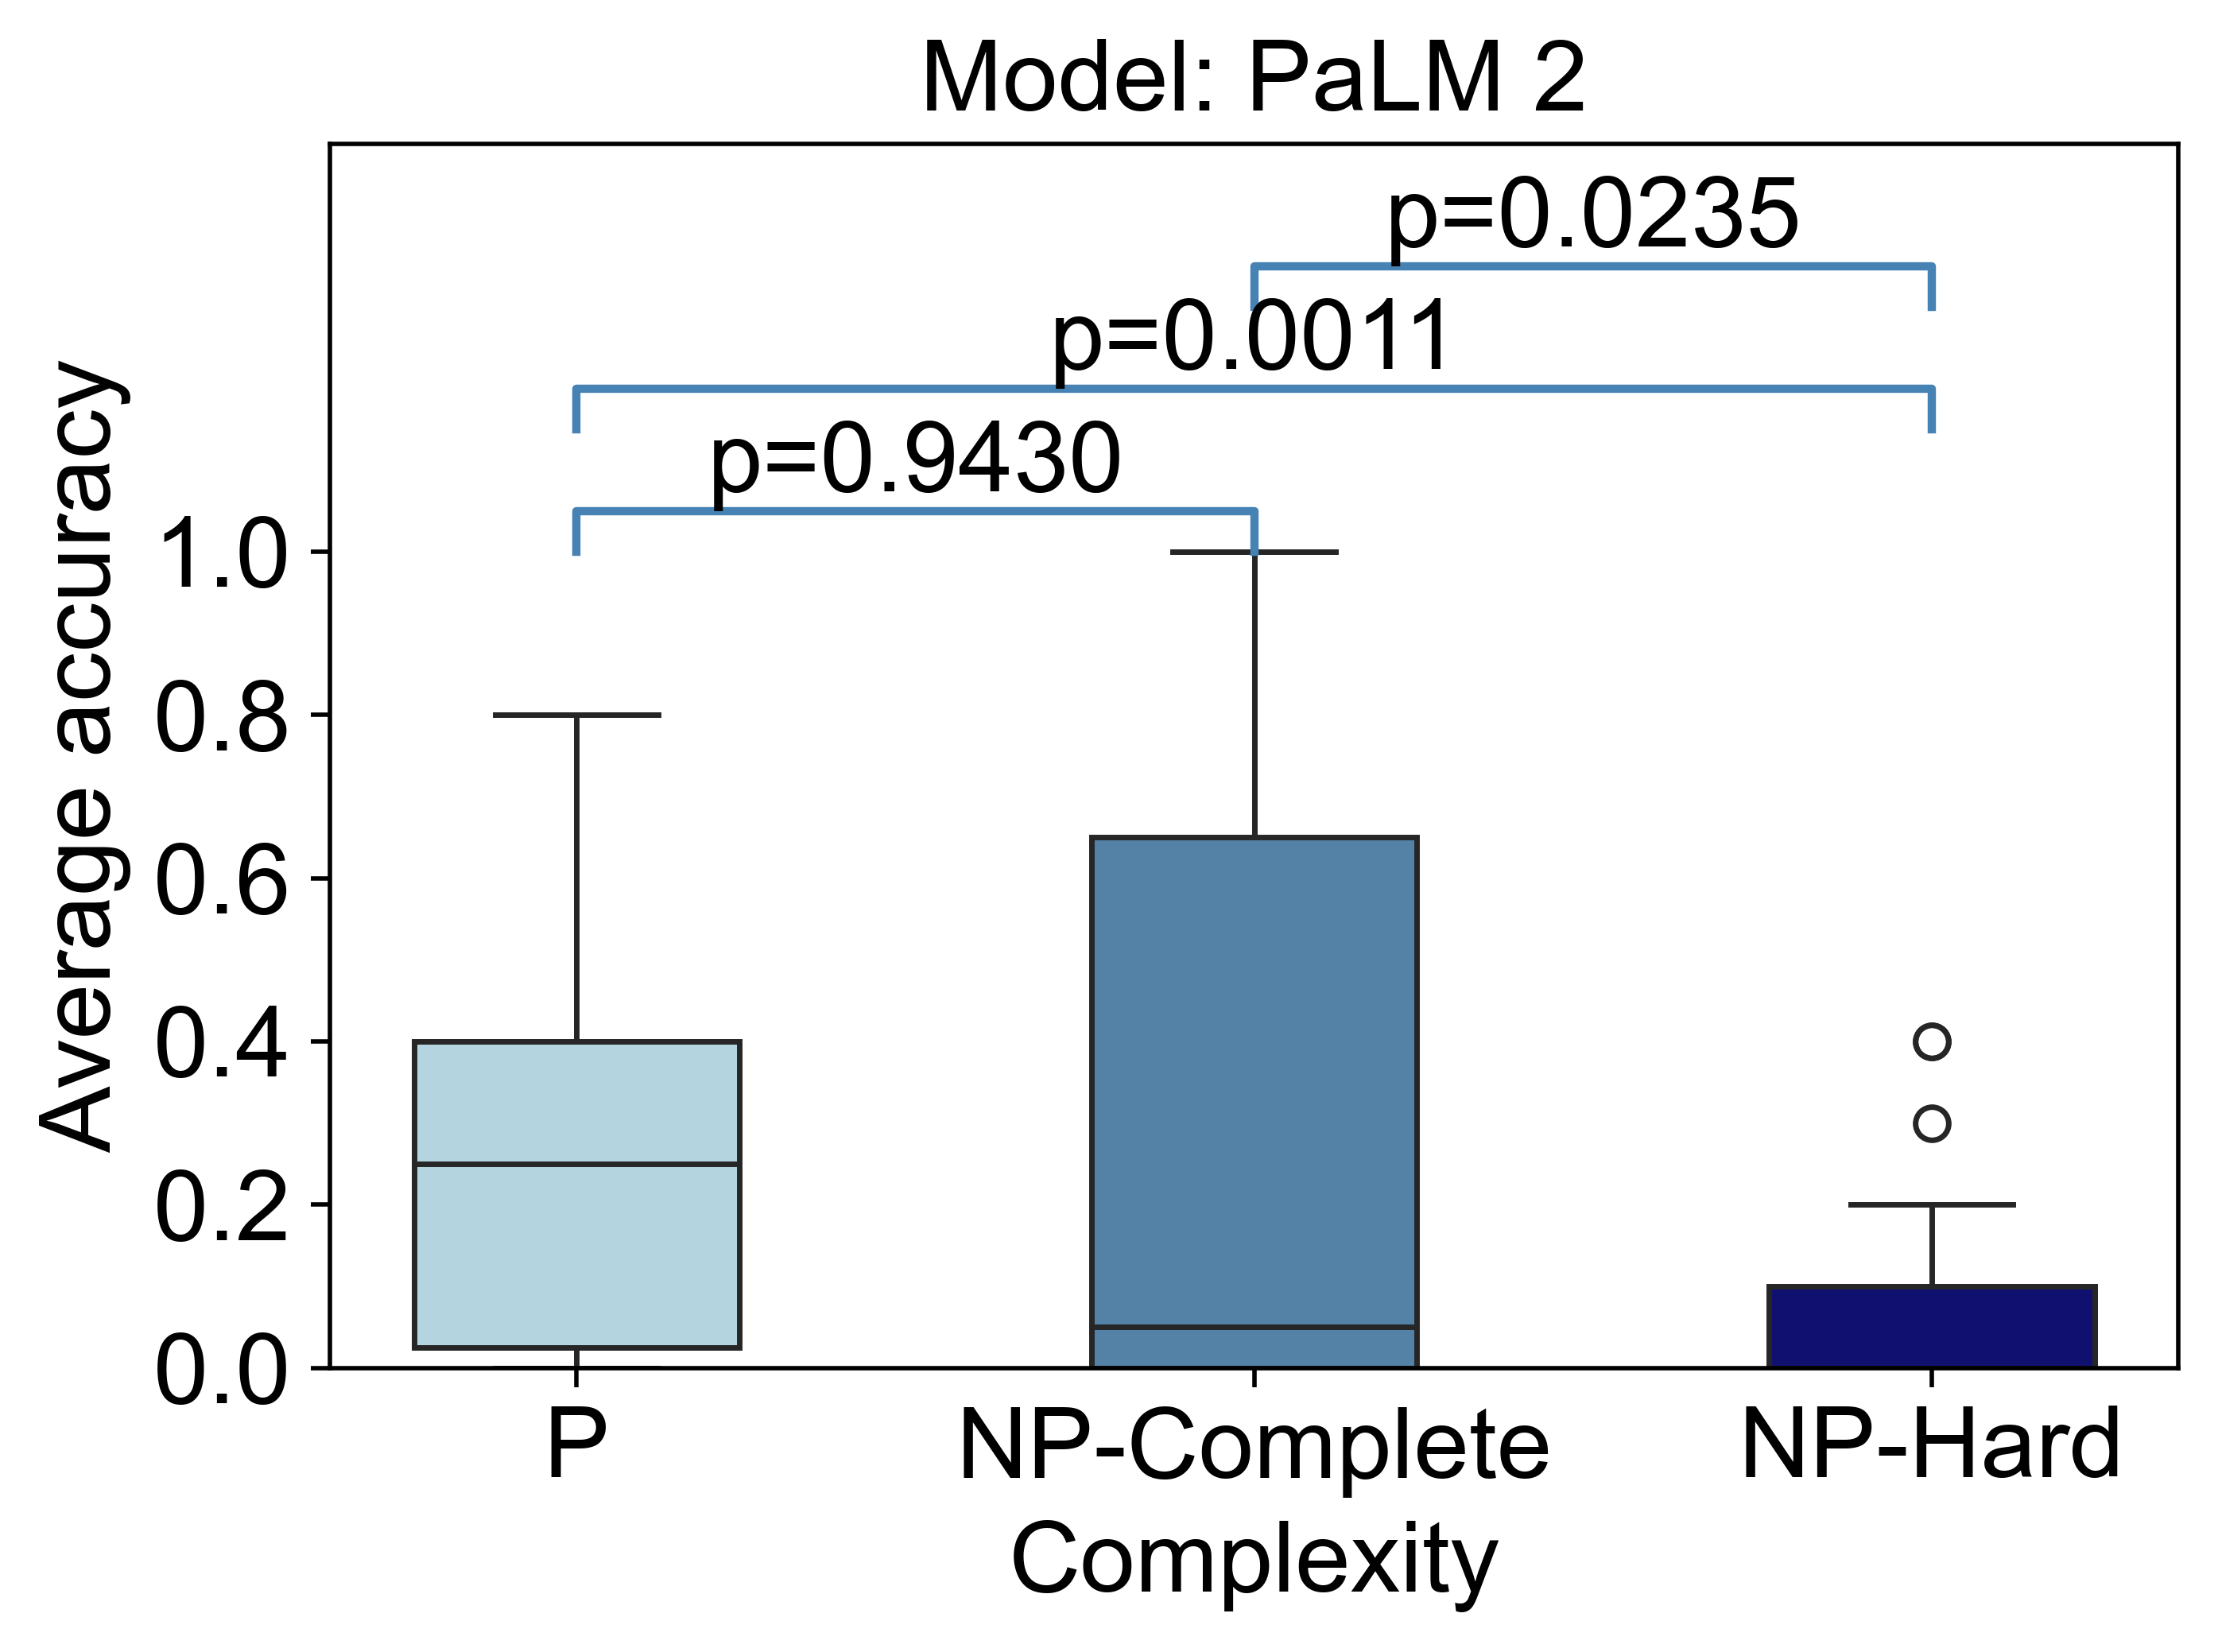

In [48]:
model = 'PaLM 2'
create_figure(model_df, model)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/var/folders/cw/l2jwfcqs4yl3k4j6btbtvjtm0000gr/T/ipykernel_8402/3156794306.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='complexity', y='Average accuracy', data=mdf, gap=.4, palette=colors)


[0.9430647257418686, 0.005183816262113403, 0.023654747527608485]


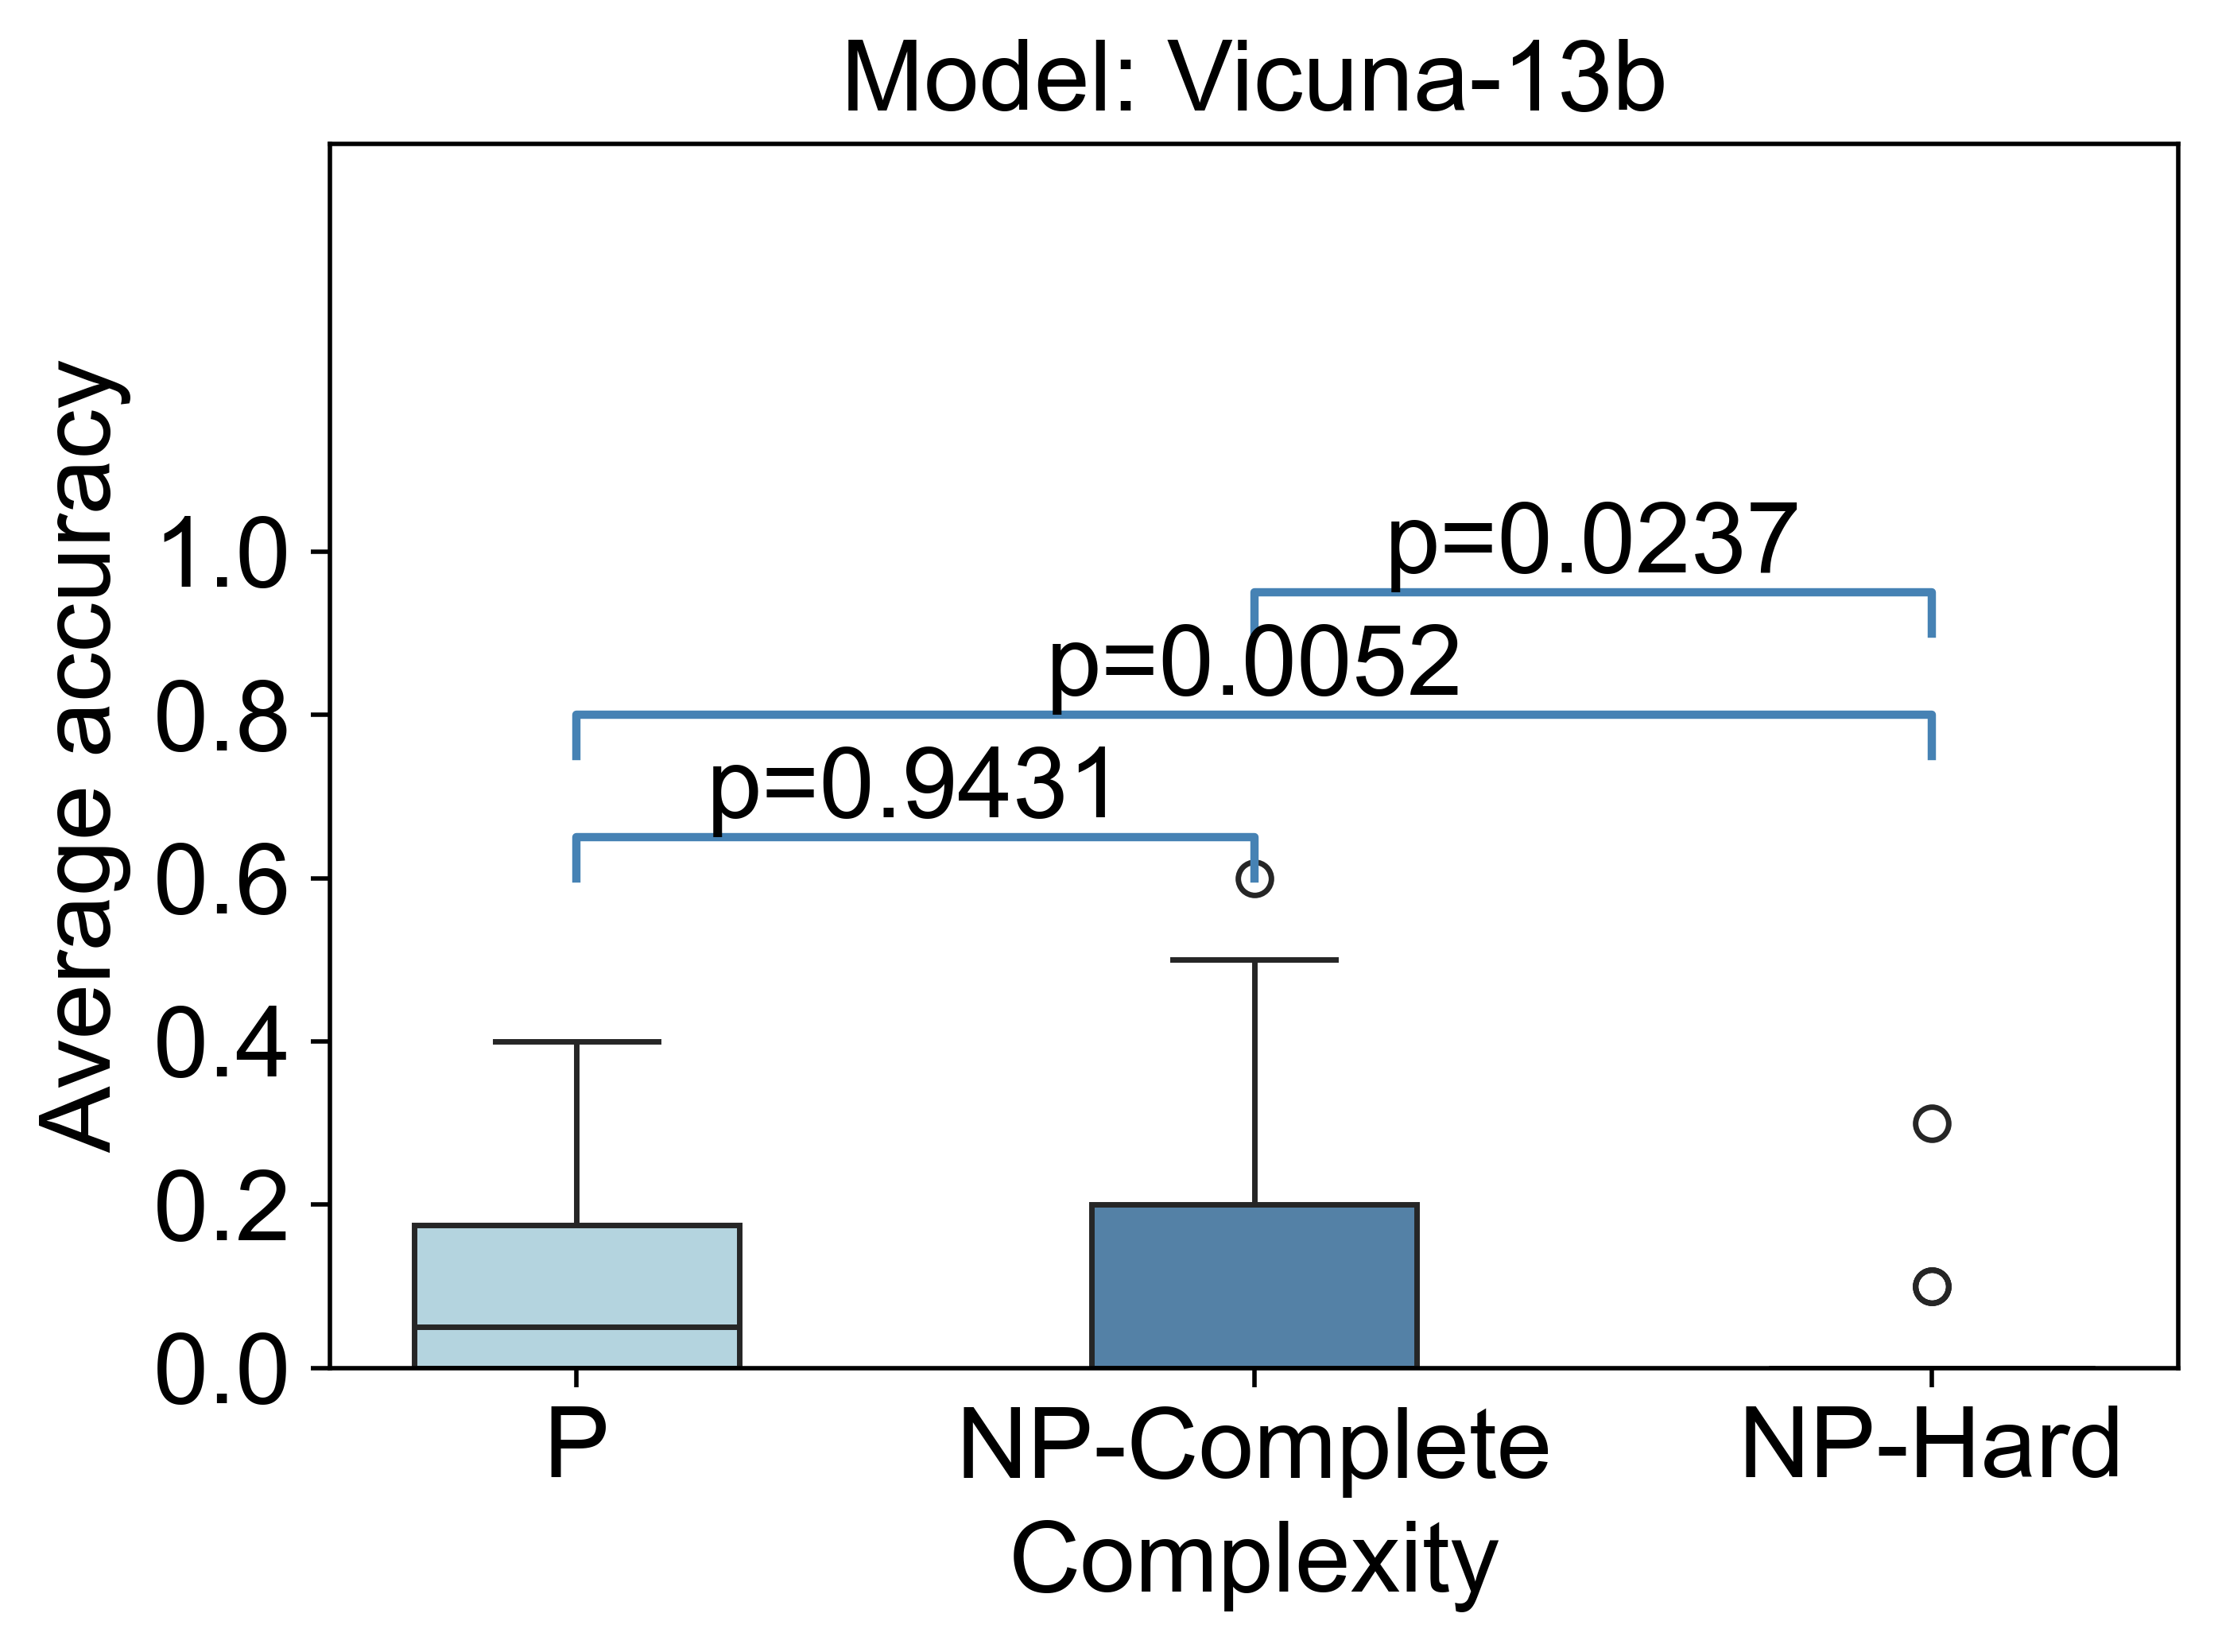

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/var/folders/cw/l2jwfcqs4yl3k4j6btbtvjtm0000gr/T/ipykernel_8402/3156794306.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='complexity', y='Average accuracy', data=mdf, gap=.4, palette=colors)


[0.001873375789256504, 0.246834259327525, 0.00042295983076825105]


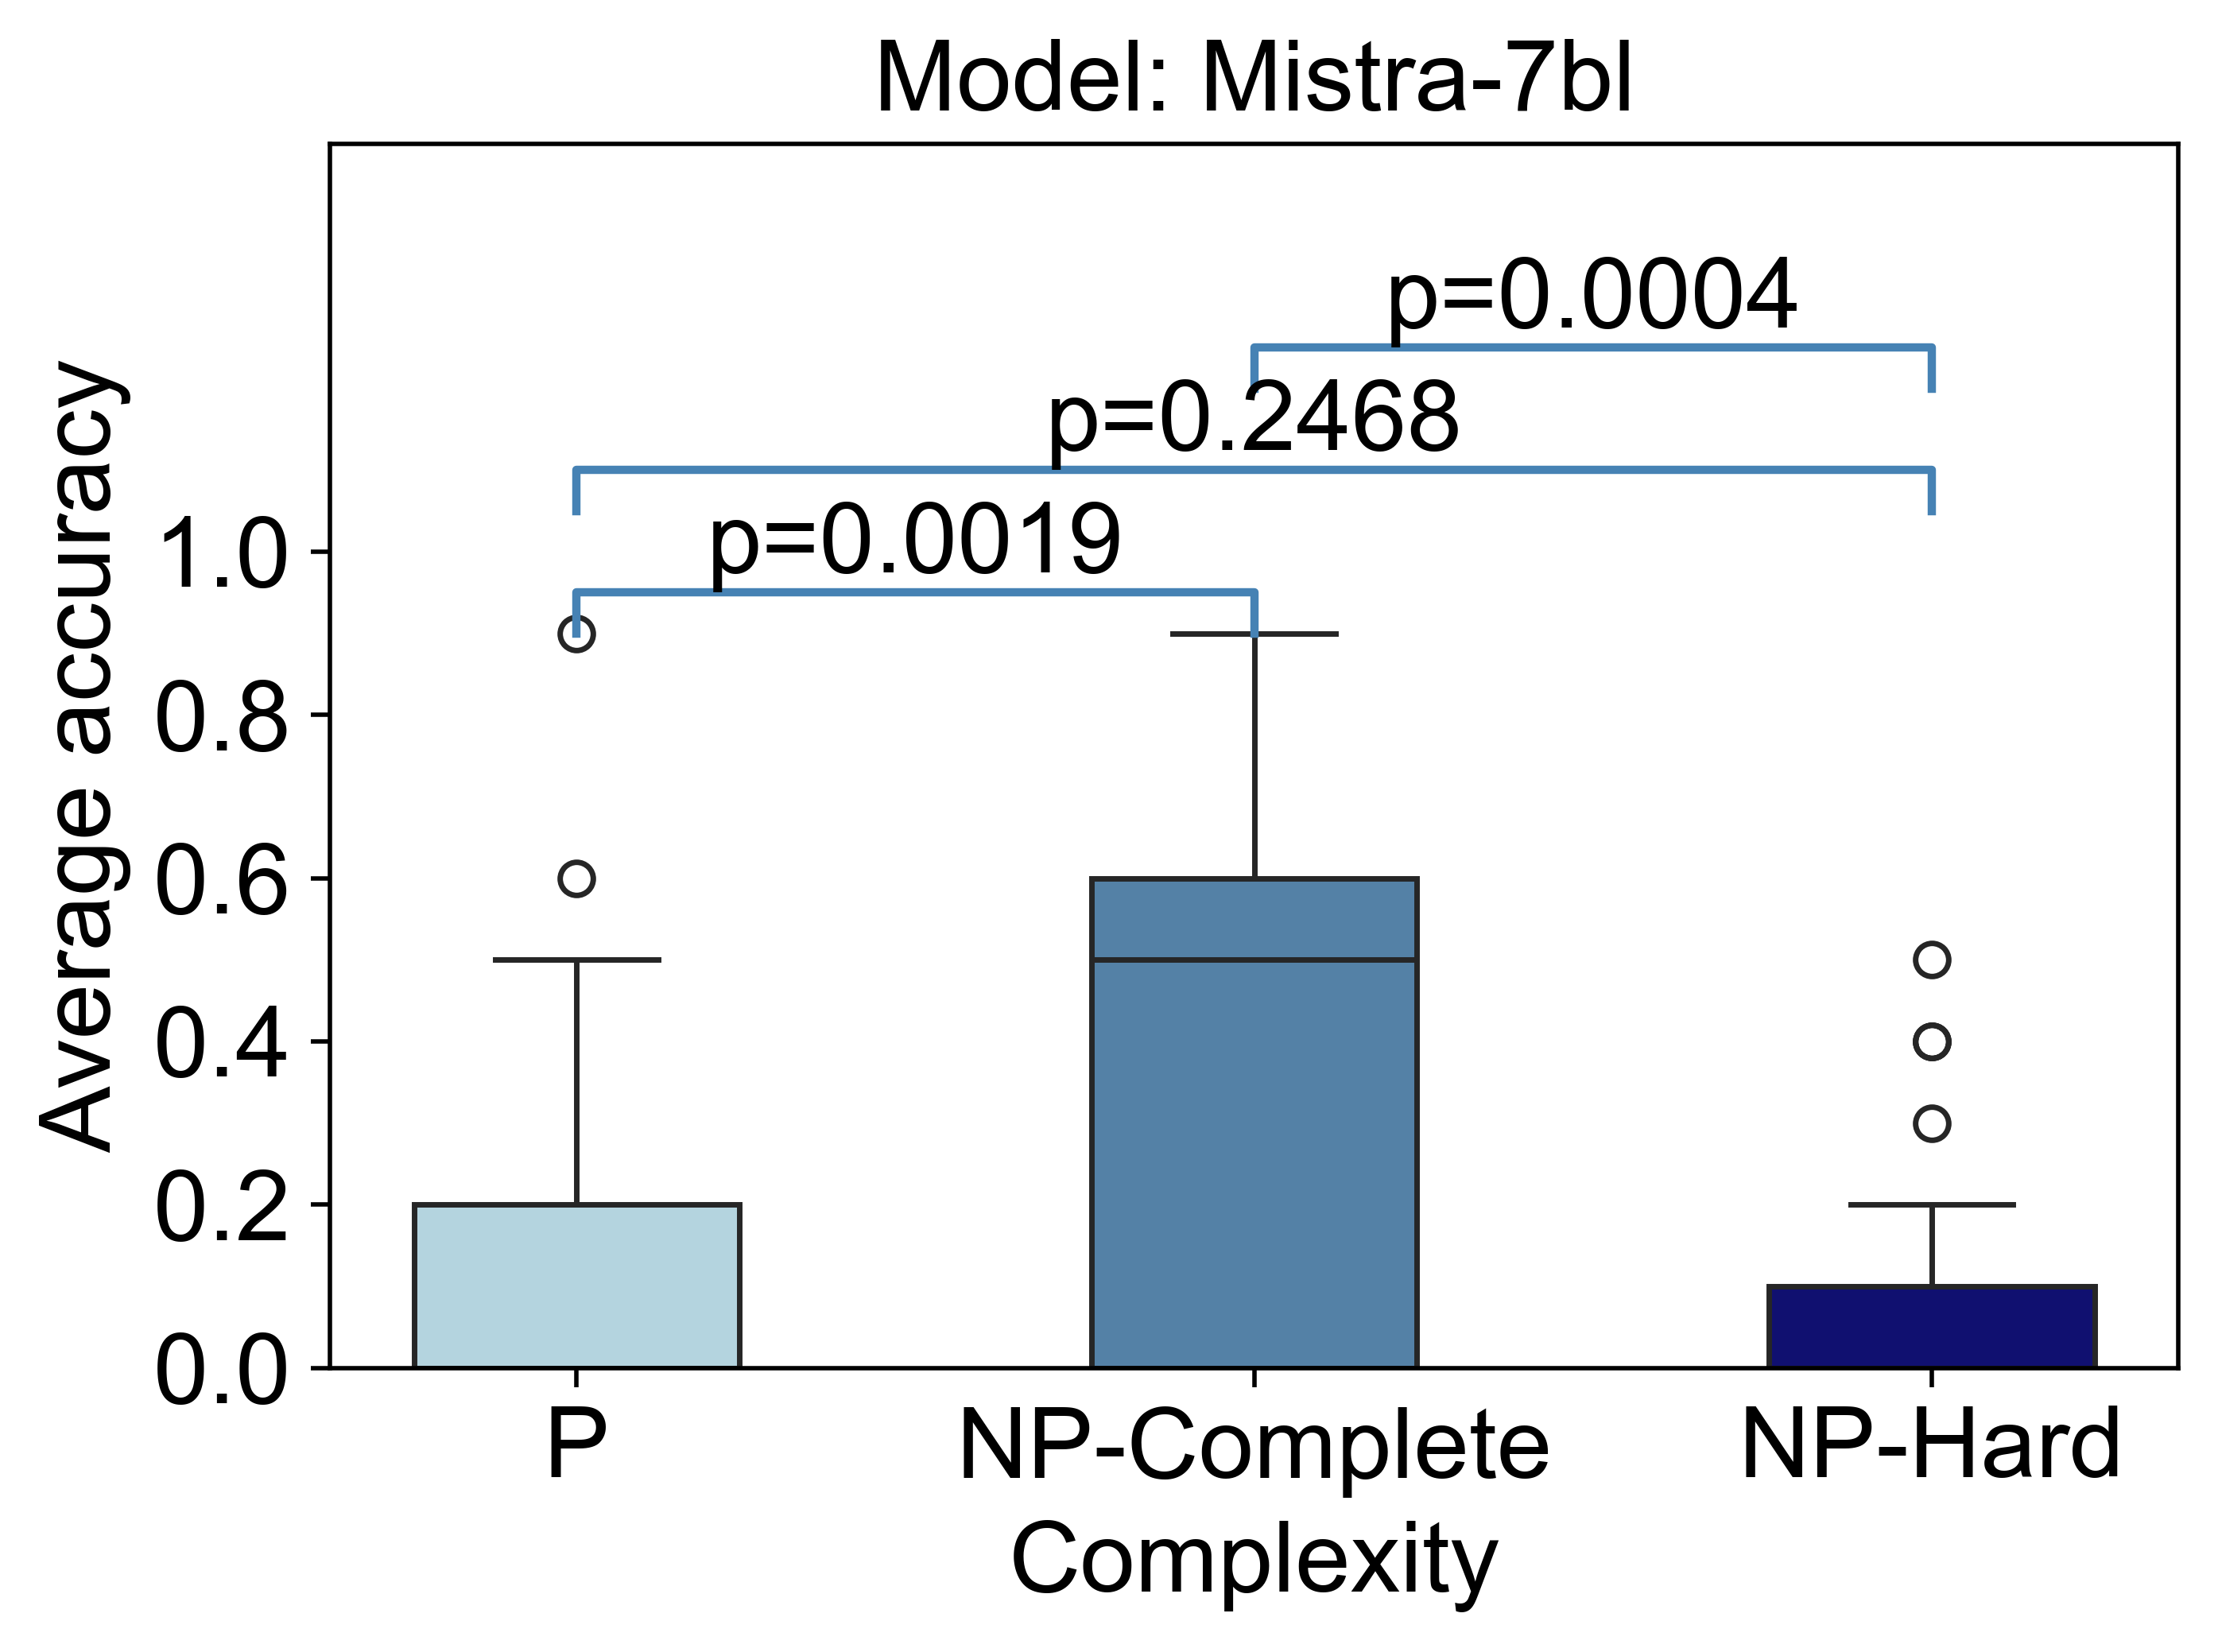

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/var/folders/cw/l2jwfcqs4yl3k4j6btbtvjtm0000gr/T/ipykernel_8402/3156794306.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='complexity', y='Average accuracy', data=mdf, gap=.4, palette=colors)


[0.2508668507812576, 1.7998214387942586e-05, 0.0001497395367063953]


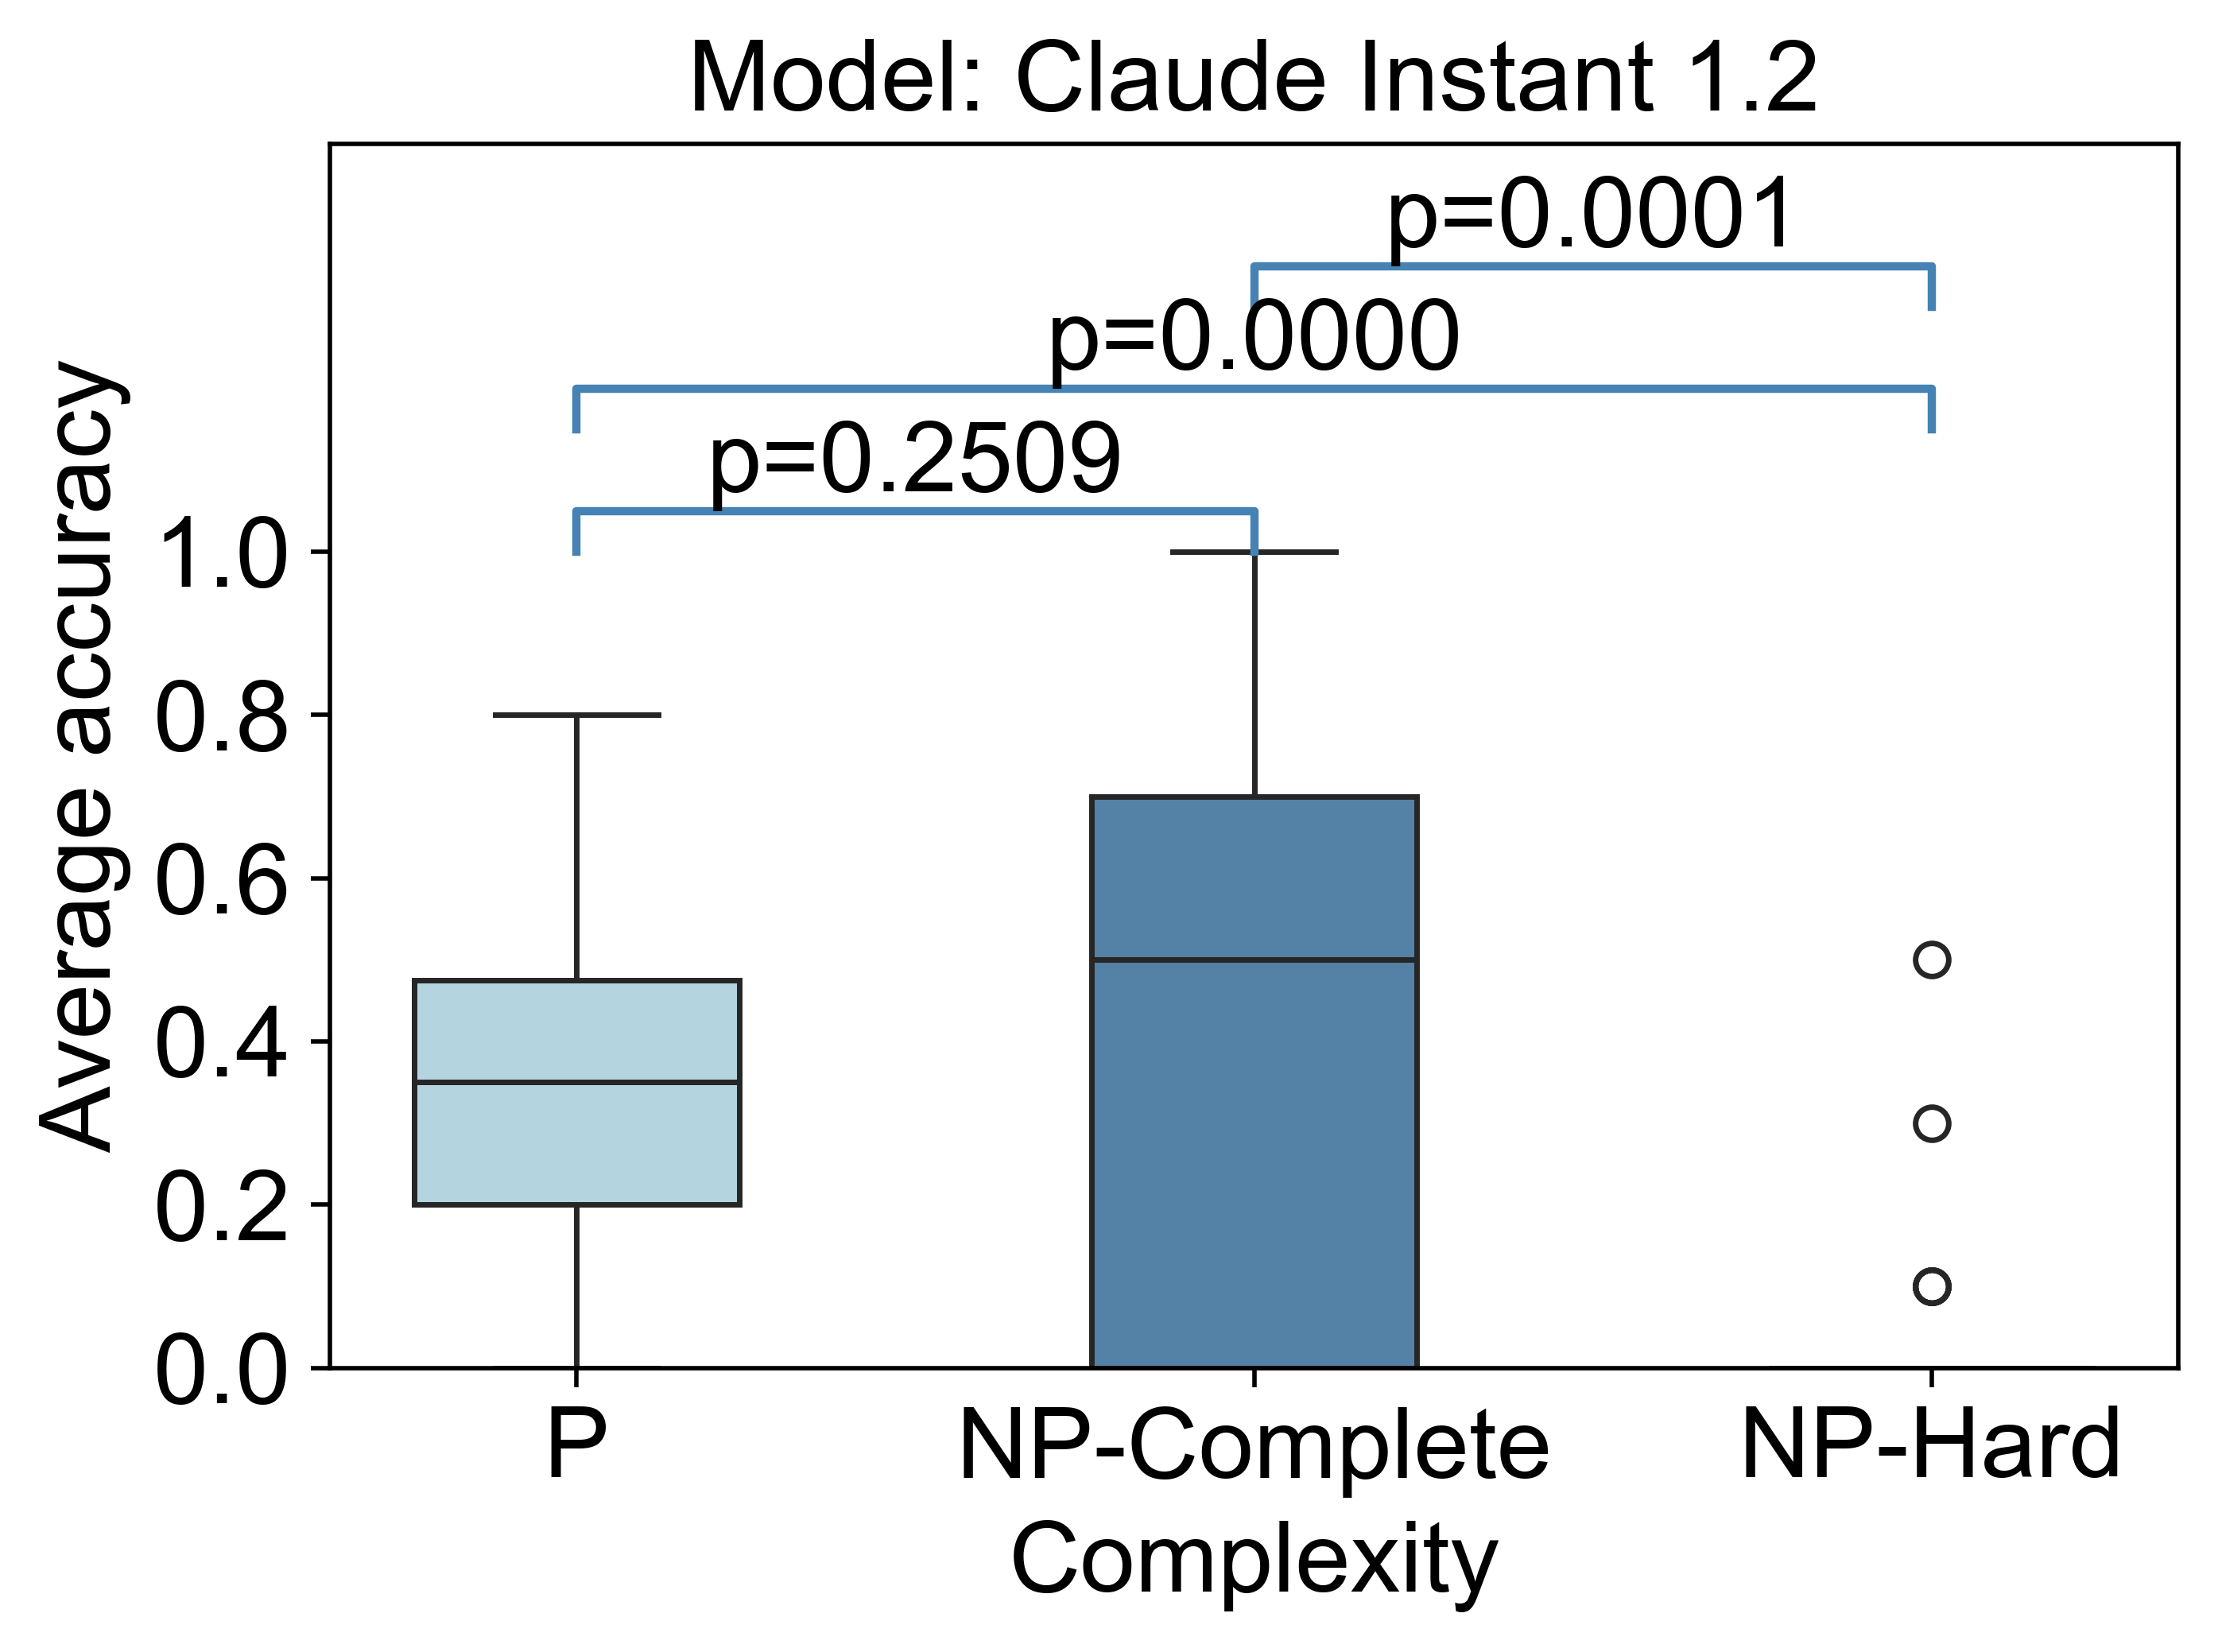

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/var/folders/cw/l2jwfcqs4yl3k4j6btbtvjtm0000gr/T/ipykernel_8402/3156794306.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='complexity', y='Average accuracy', data=mdf, gap=.4, palette=colors)


[0.0014320951027634863, 3.615075117045866e-06, 0.029053772133898245]


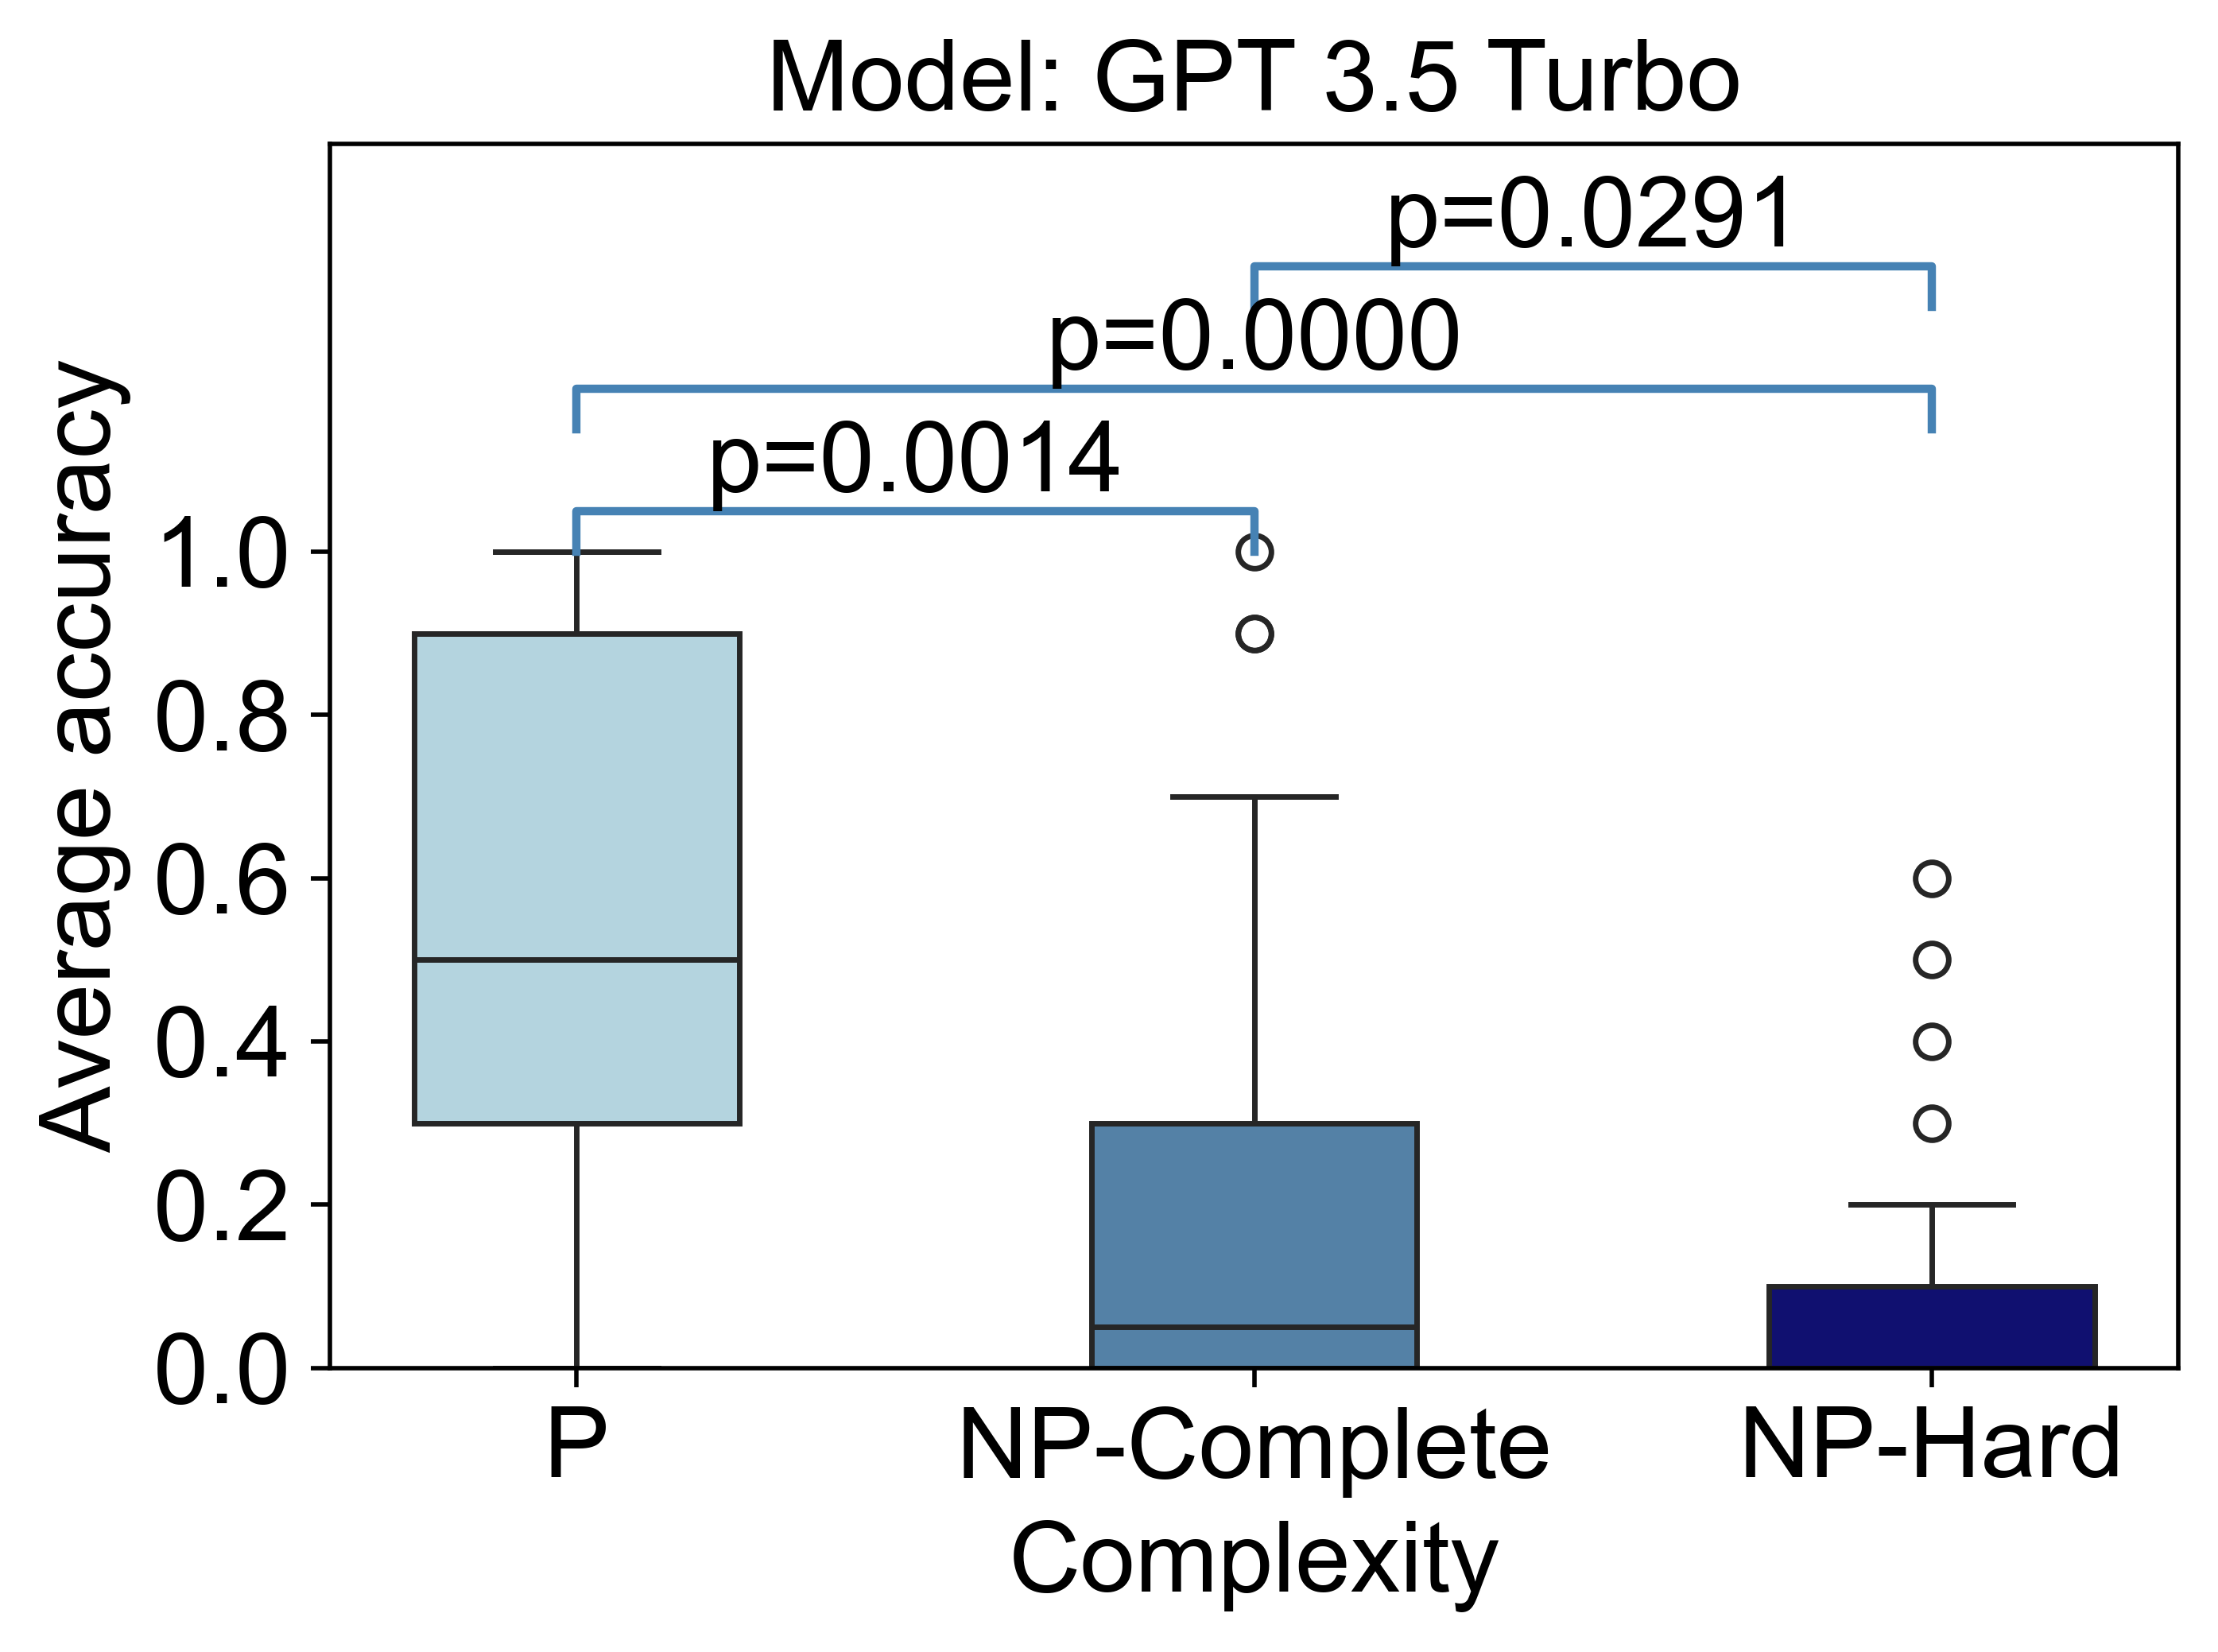

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/var/folders/cw/l2jwfcqs4yl3k4j6btbtvjtm0000gr/T/ipykernel_8402/3156794306.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='complexity', y='Average accuracy', data=mdf, gap=.4, palette=colors)


[0.942966547096481, 0.001105231734859981, 0.023497860877545986]


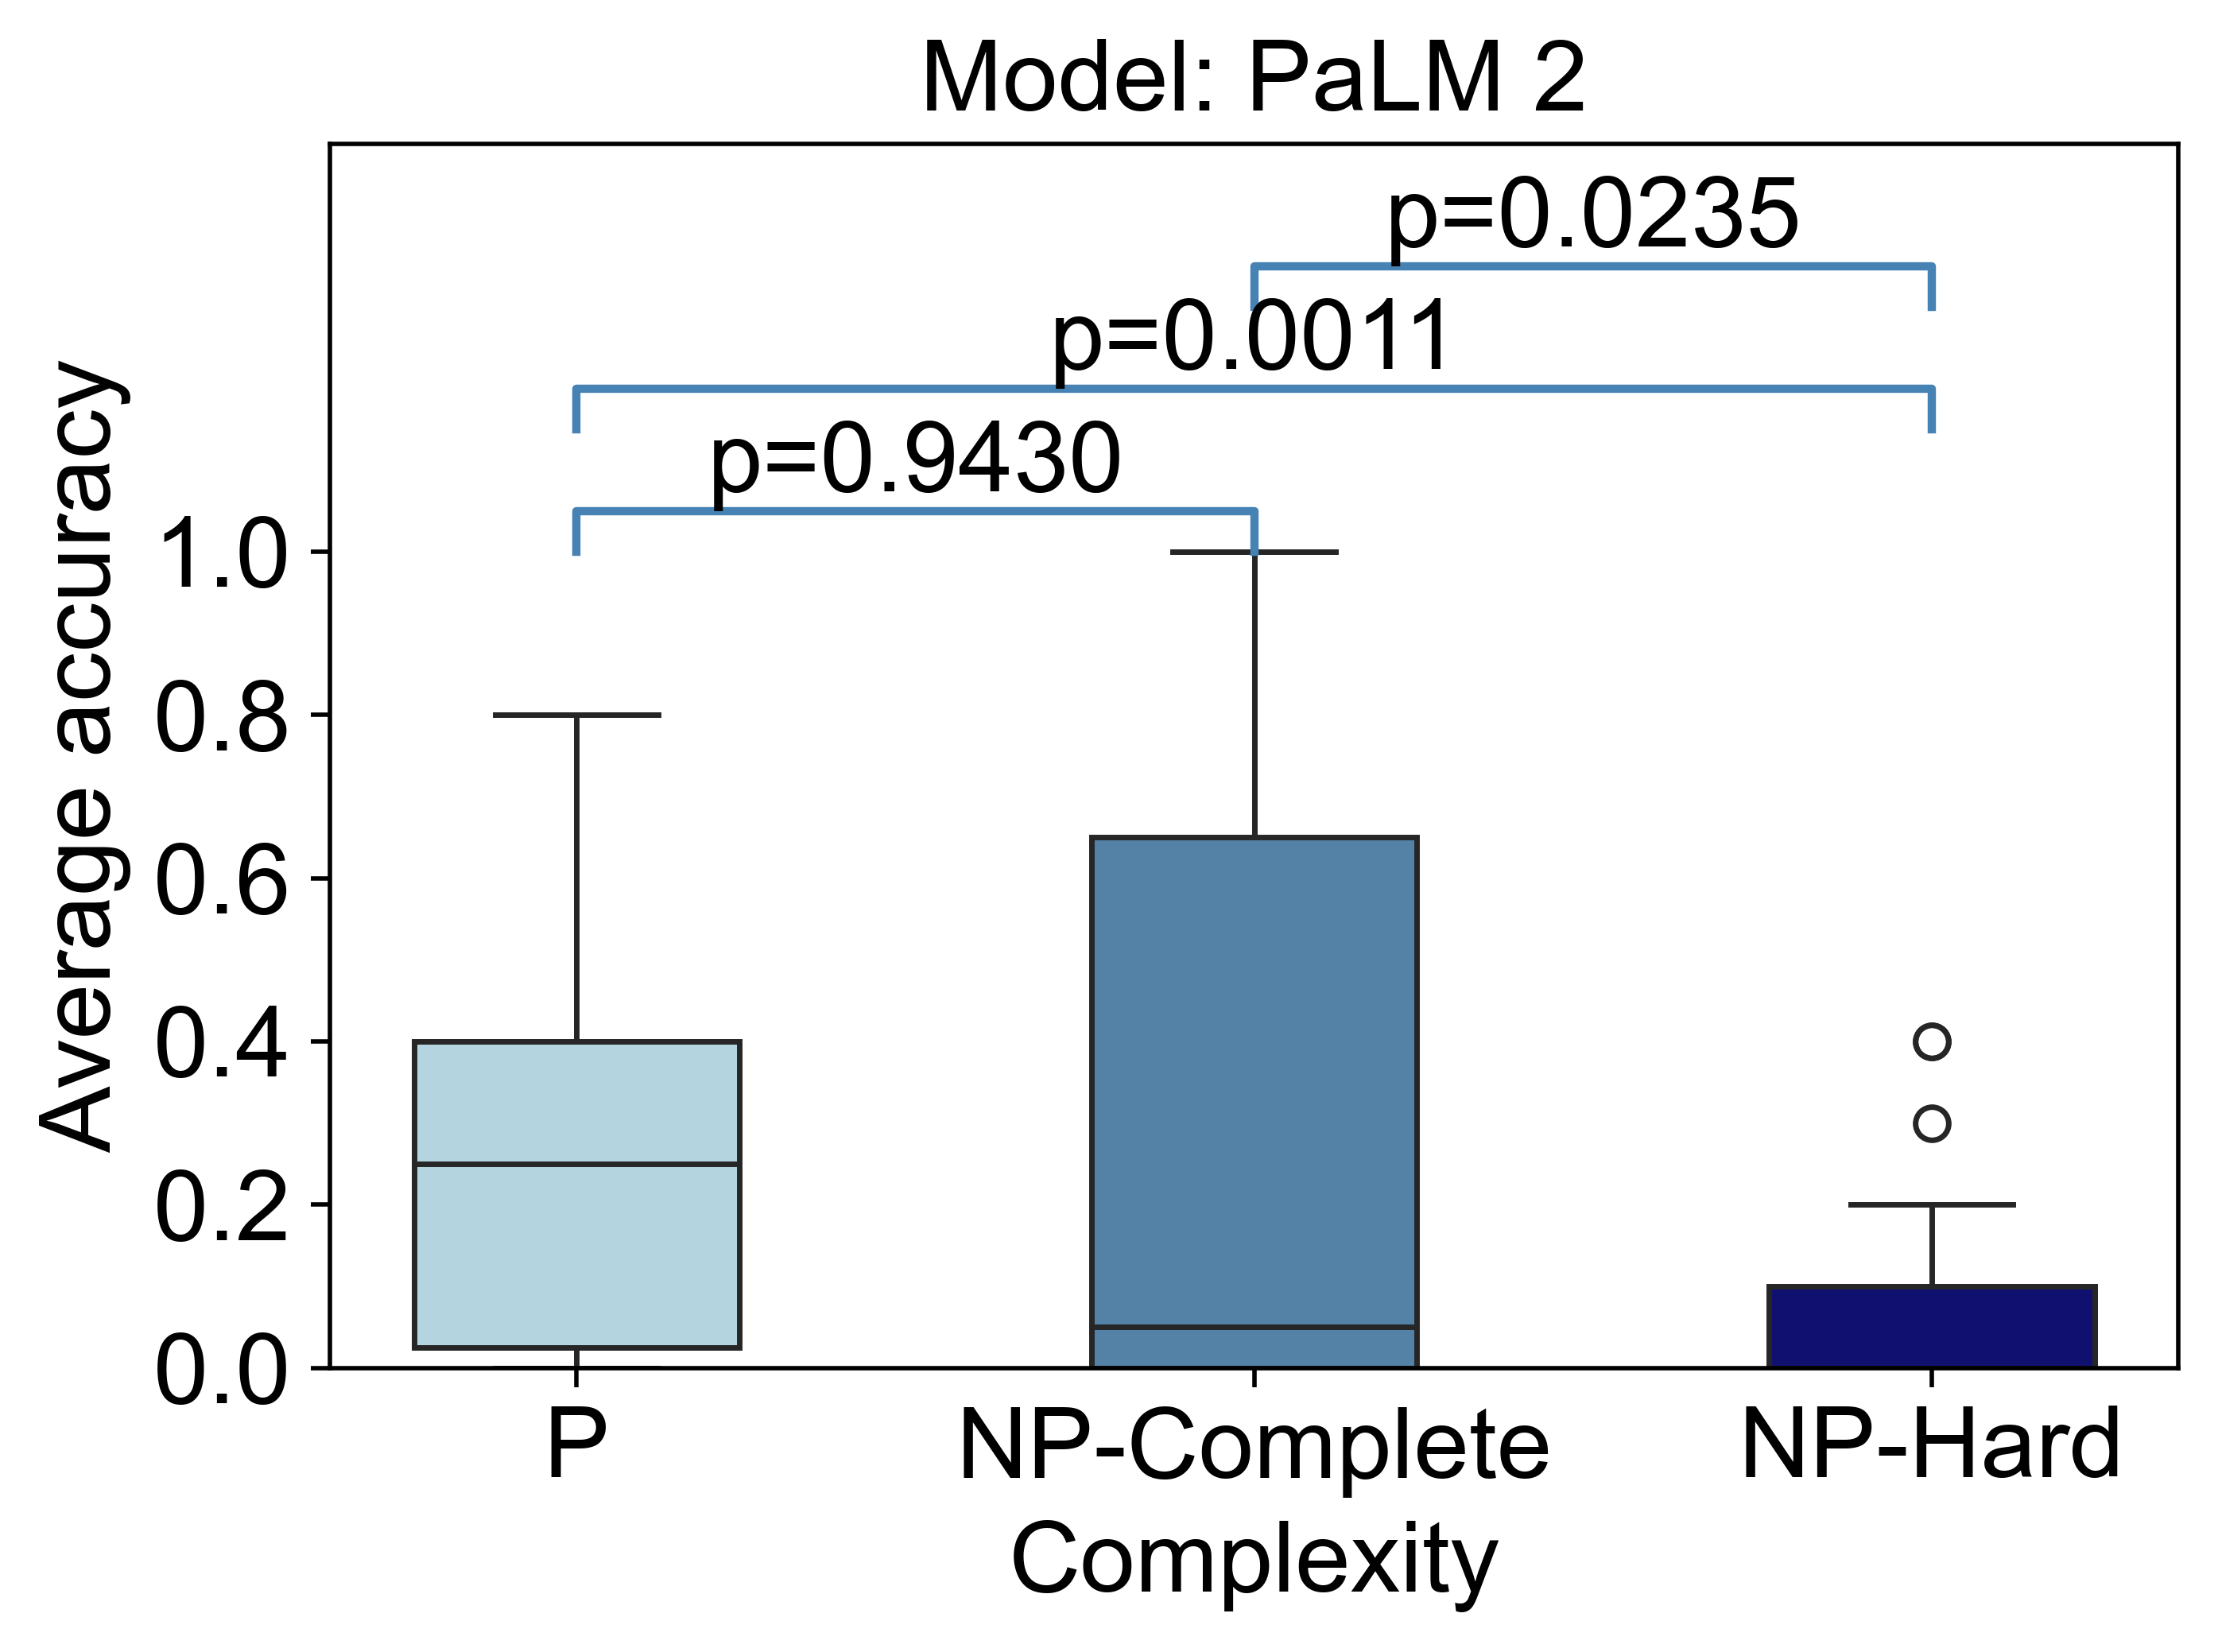

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/var/folders/cw/l2jwfcqs4yl3k4j6btbtvjtm0000gr/T/ipykernel_8402/3156794306.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='complexity', y='Average accuracy', data=mdf, gap=.4, palette=colors)


[0.0012130182784309373, 1.862645149230957e-09, 4.8197666738556997e-05]


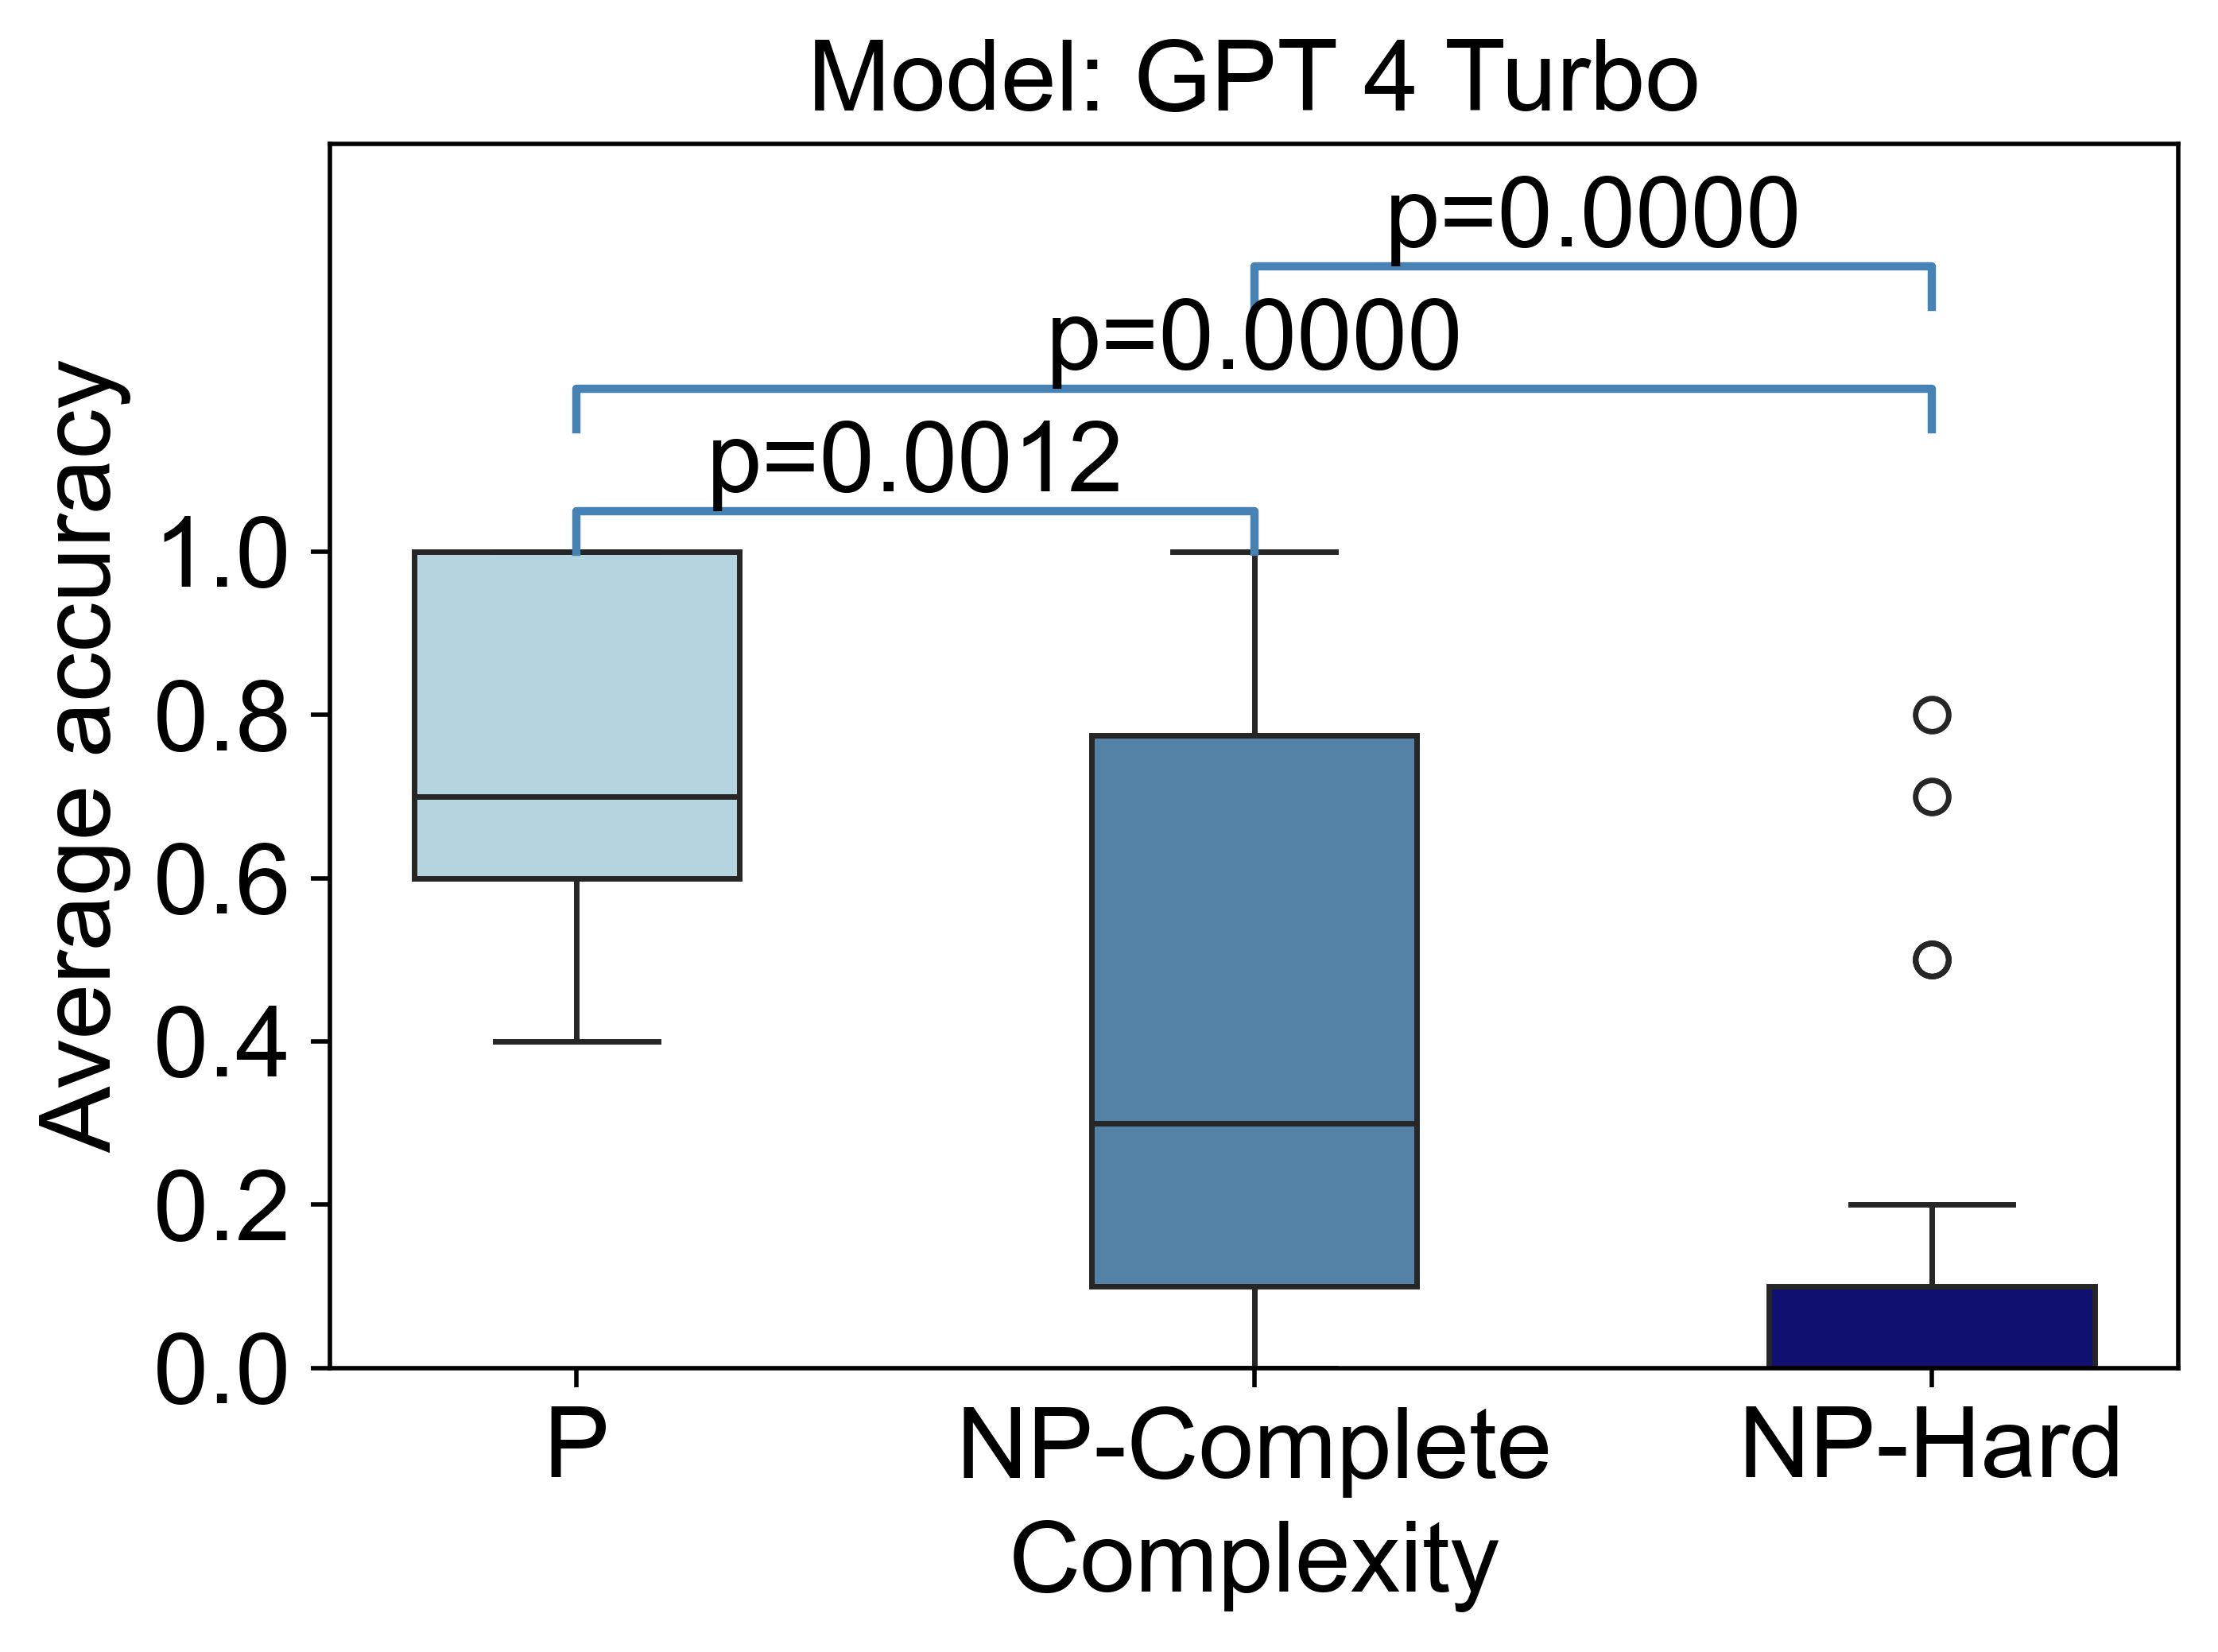

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/var/folders/cw/l2jwfcqs4yl3k4j6btbtvjtm0000gr/T/ipykernel_8402/3156794306.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='complexity', y='Average accuracy', data=mdf, gap=.4, palette=colors)


[0.22855282202363014, 1.721579998751834e-05, 4.762520082798508e-05]


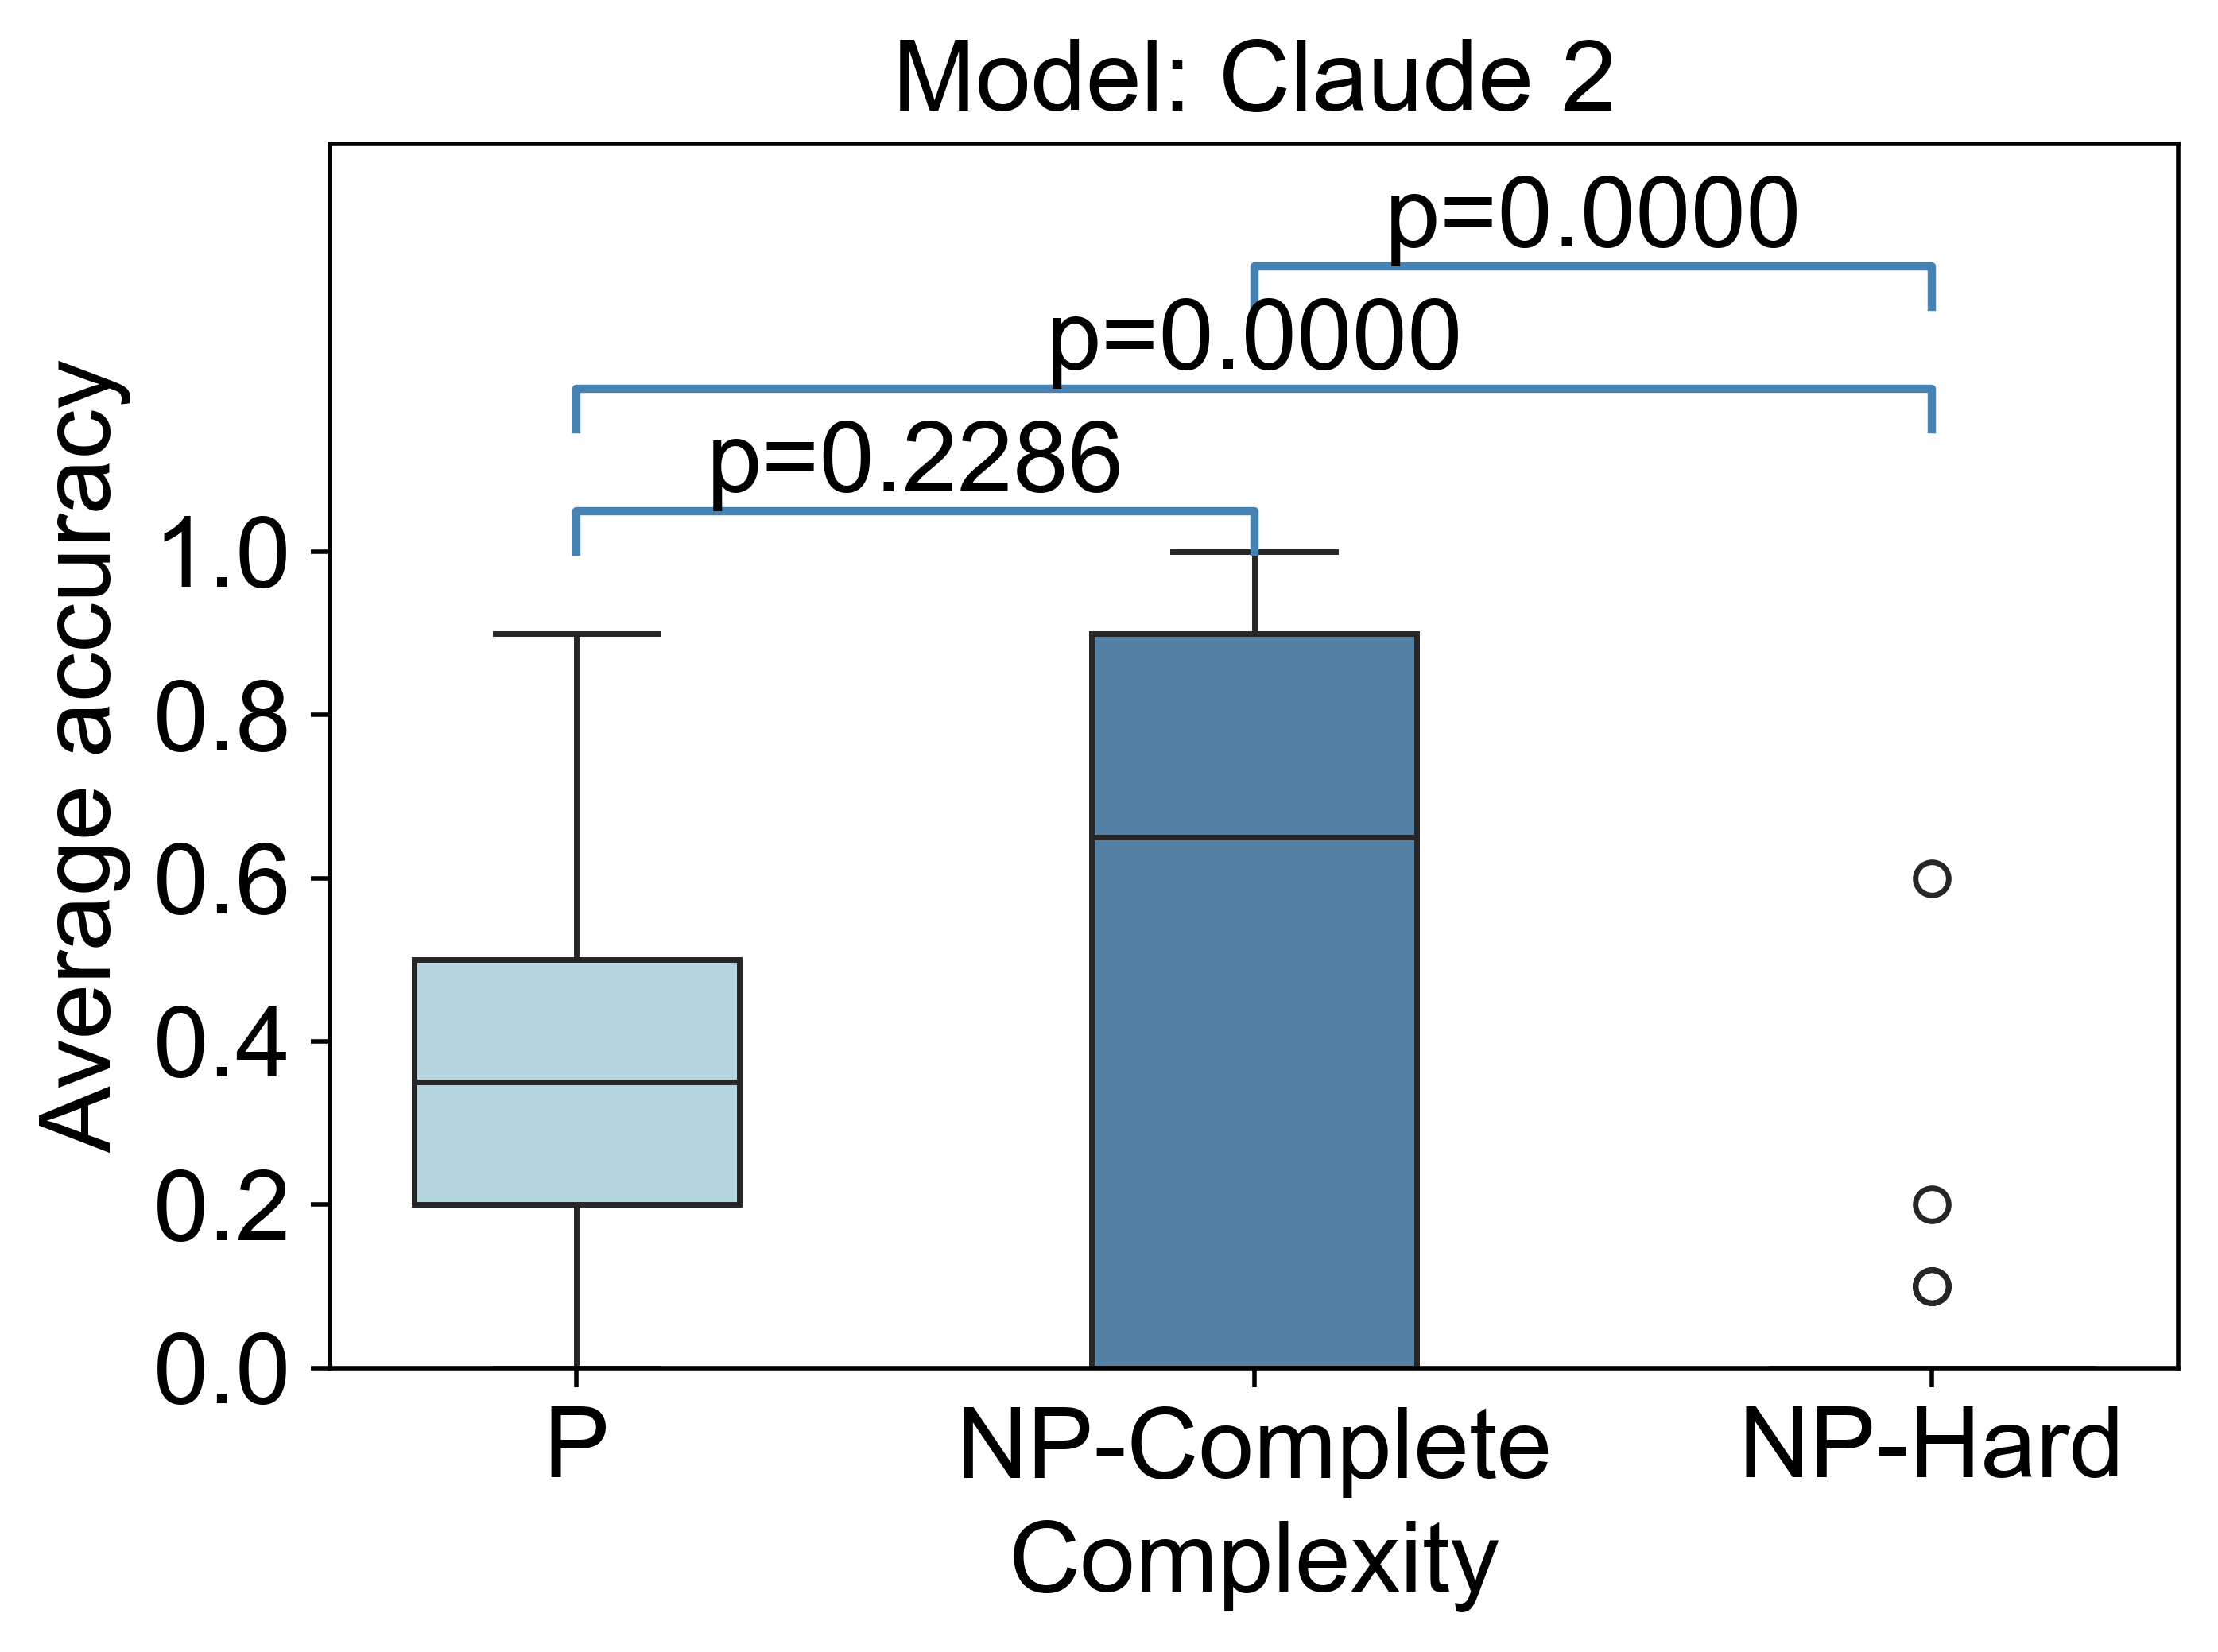

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/var/folders/cw/l2jwfcqs4yl3k4j6btbtvjtm0000gr/T/ipykernel_8402/3156794306.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='complexity', y='Average accuracy', data=mdf, gap=.4, palette=colors)


[0.31731050786291415, 0.31731050786291415, 1.0]


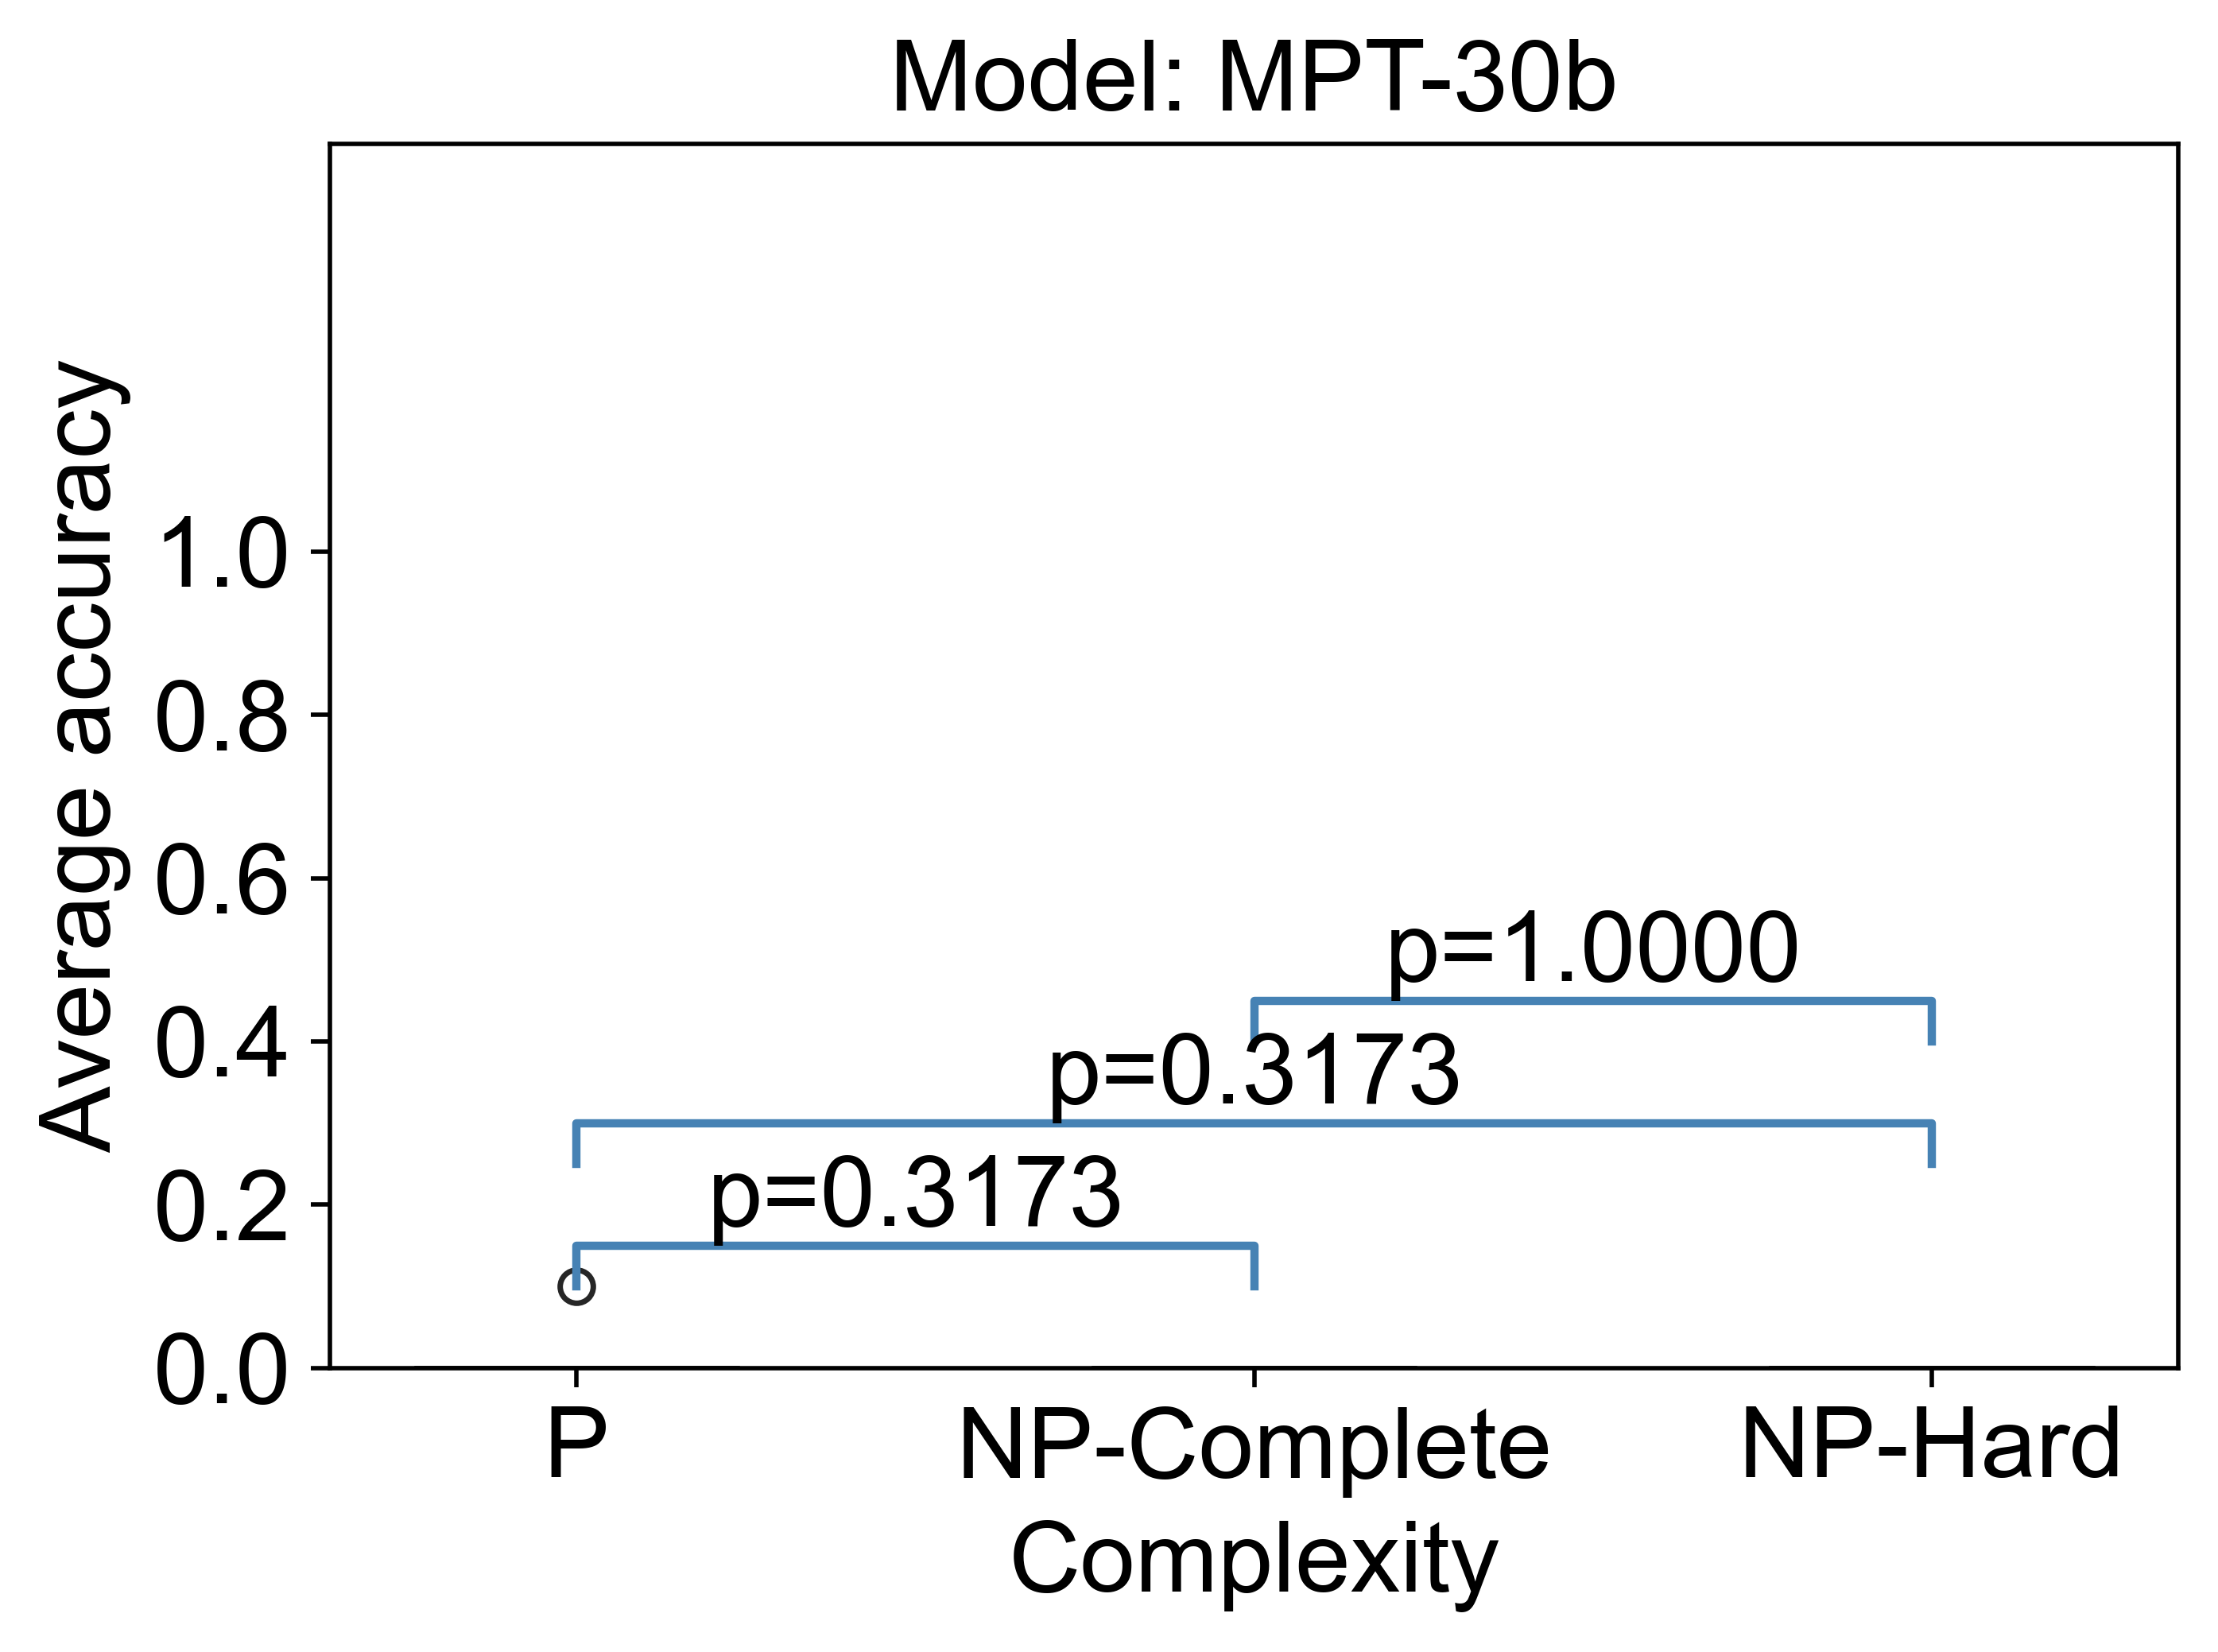

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/var/folders/cw/l2jwfcqs4yl3k4j6btbtvjtm0000gr/T/ipykernel_8402/3156794306.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='complexity', y='Average accuracy', data=mdf, gap=.4, palette=colors)


[0.8794378429214196, 0.0003324170809957377, 0.0001808447927739847]


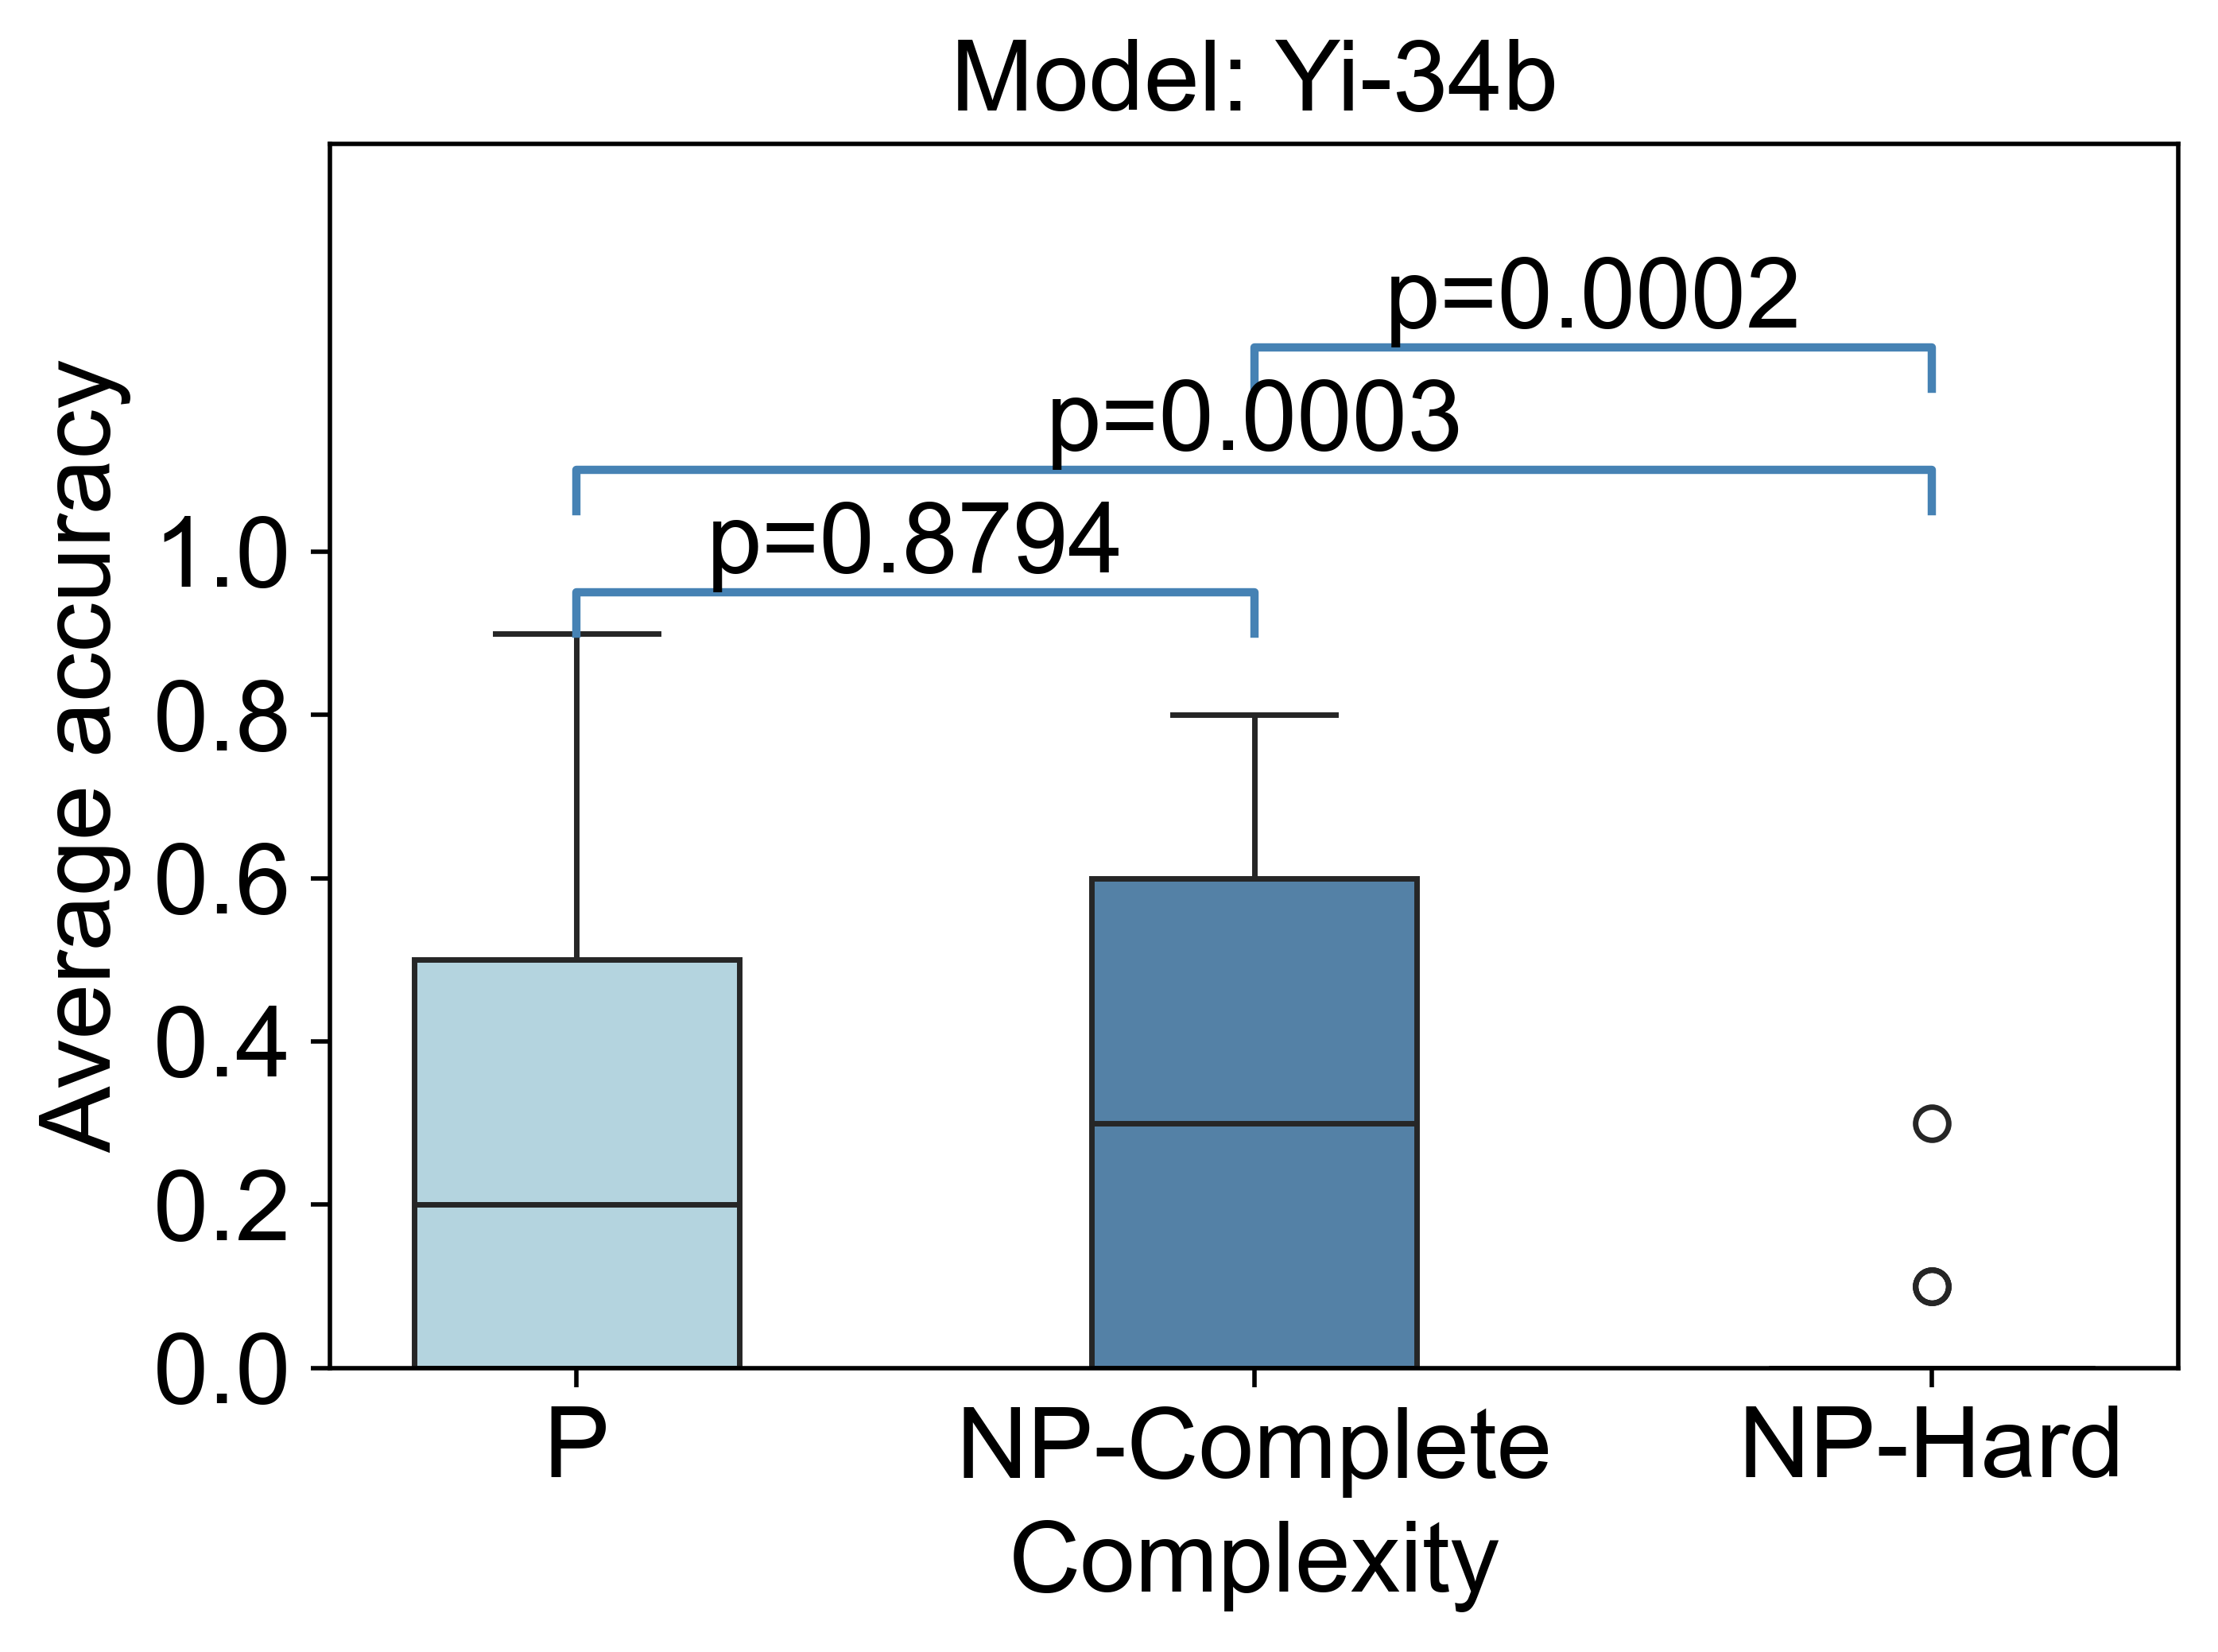

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/var/folders/cw/l2jwfcqs4yl3k4j6btbtvjtm0000gr/T/ipykernel_8402/3156794306.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='complexity', y='Average accuracy', data=mdf, gap=.4, palette=colors)


[1.0, 0.15729920705028502, 0.15729920705028502]


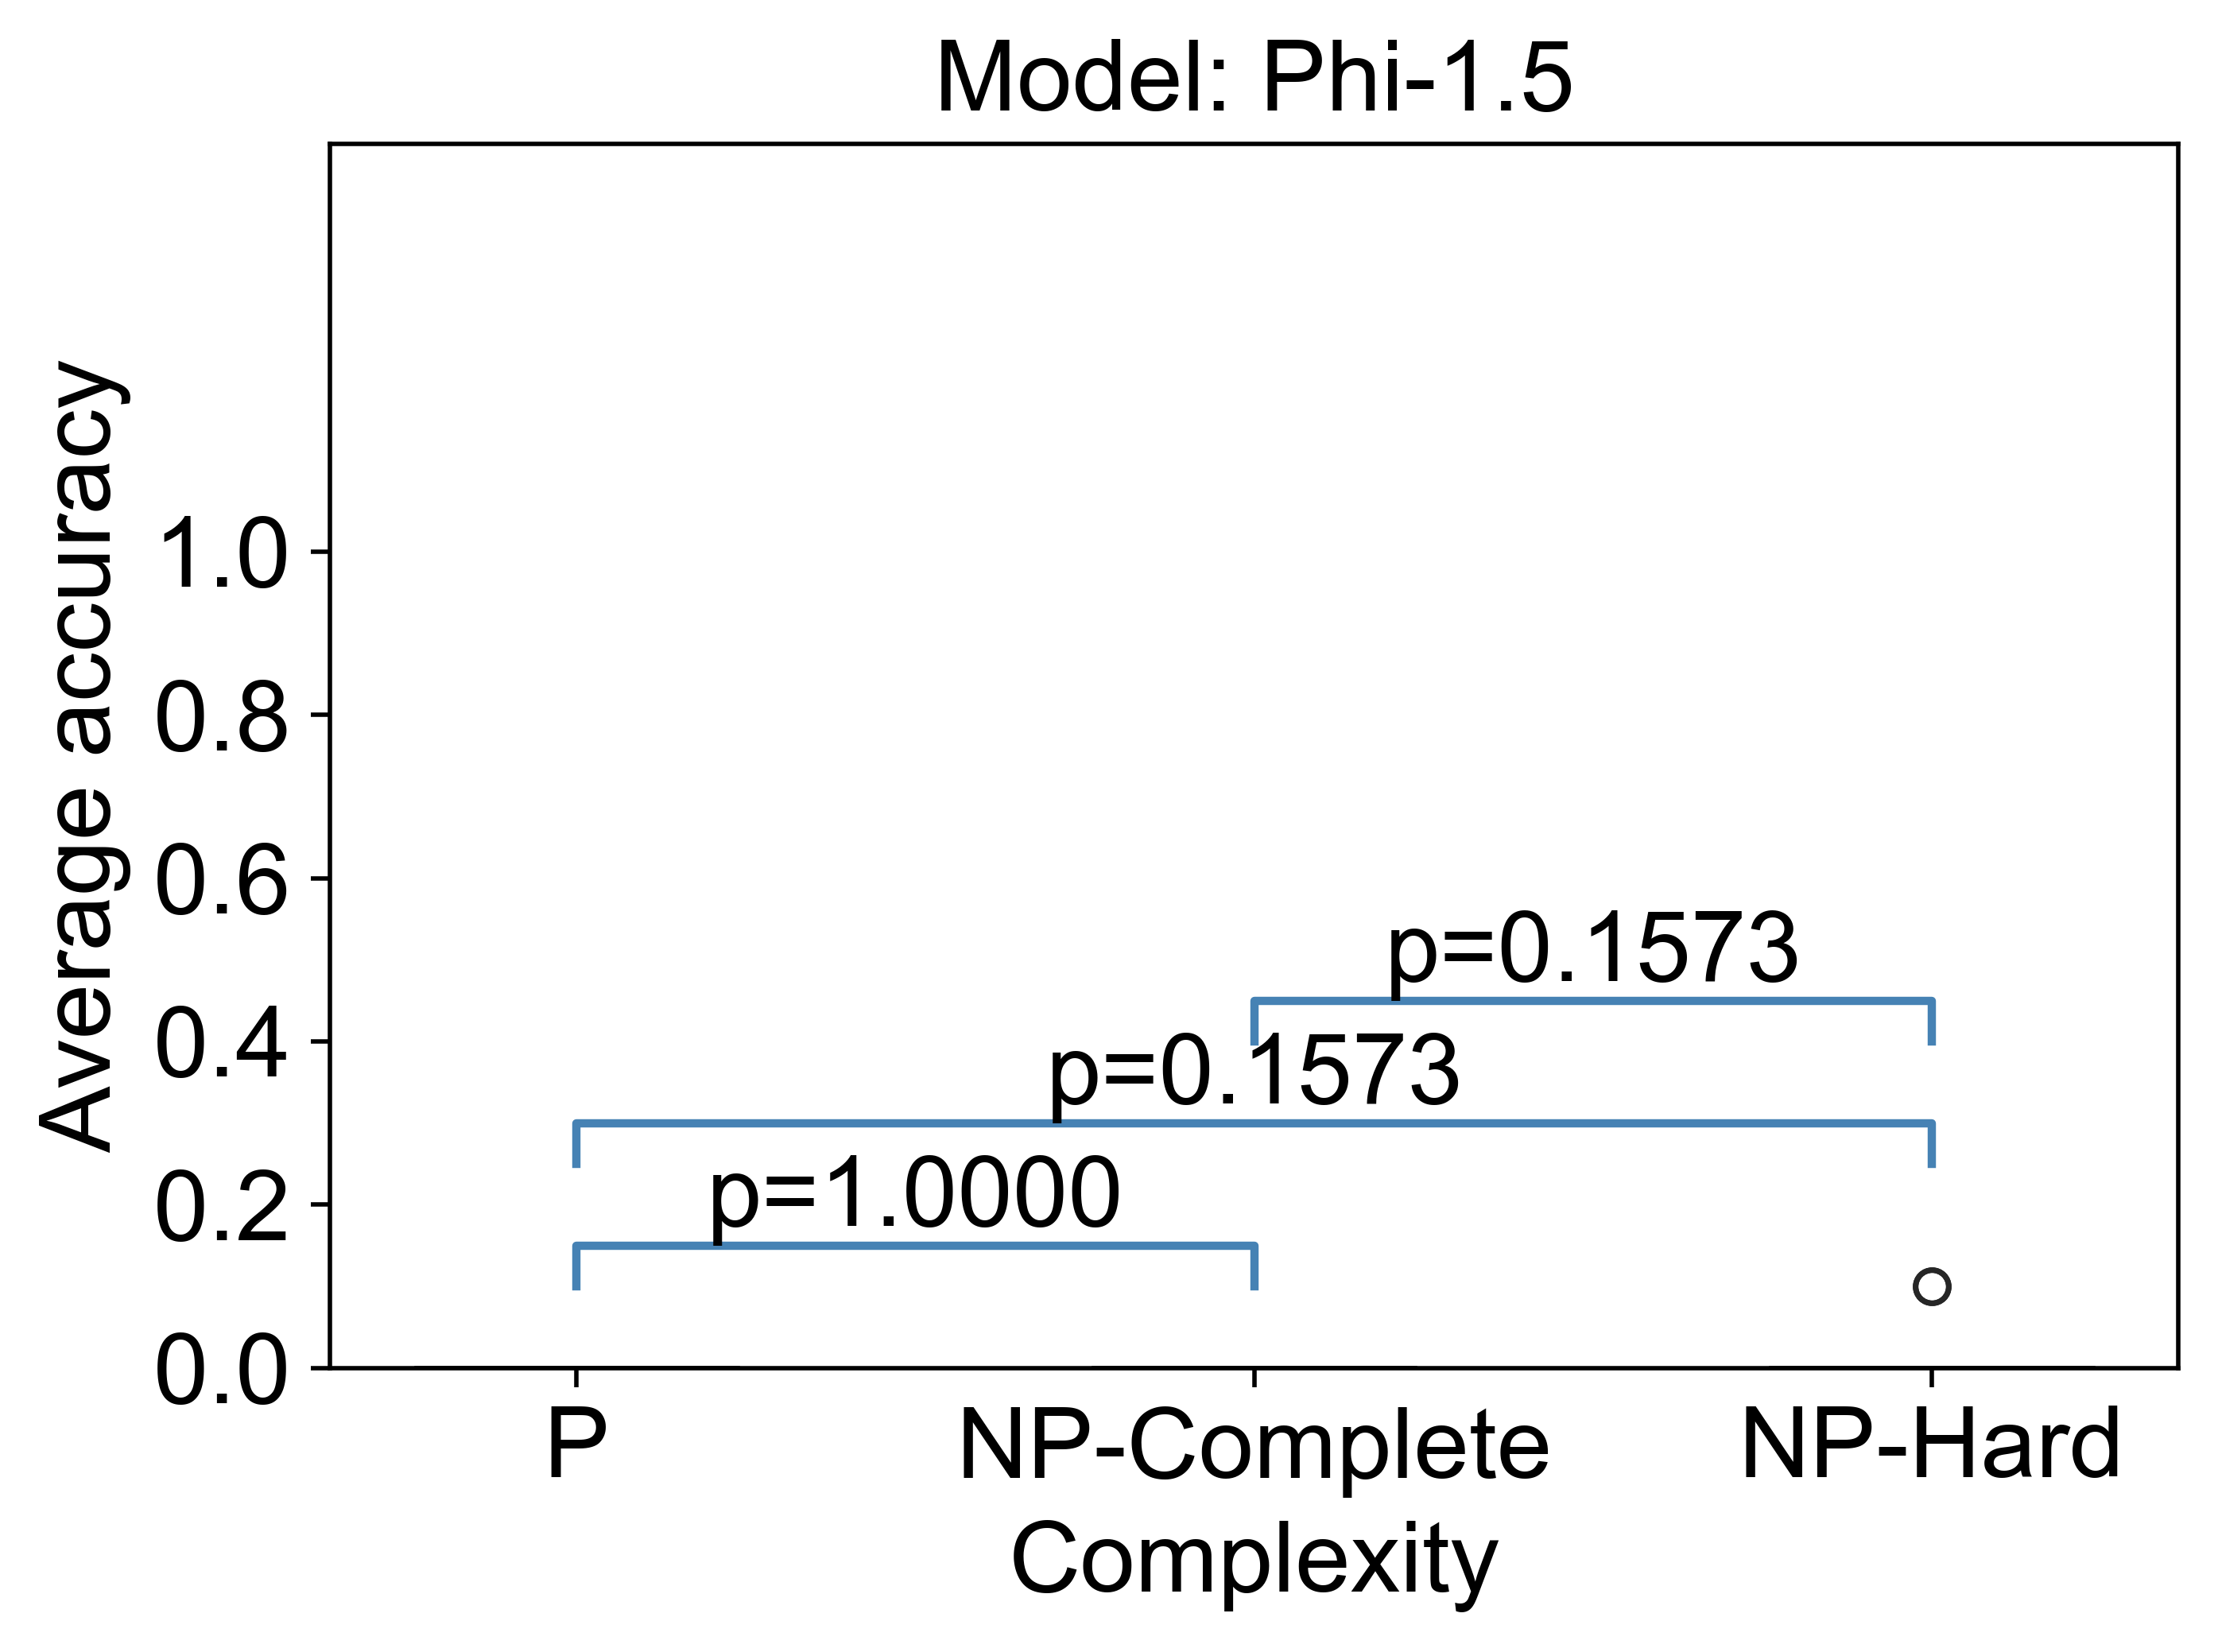

In [49]:
models = df['model'].unique()
for model in models:
    create_figure(model_df, model)